# TLDR
Given a camera's physical characteristics, predict lens distortion parameters.


# Data directory and globals

In [25]:
from pathlib import Path

basedir = Path('camflex-data')

# Define the directory containing the lens data (this is a private repository)
lensdatadir = Path('camflex-data/data')

# Define the output CSV file path
output_csv_path =Path('camflex-data/training_data.csv')

# Path to the PDF file containing the lens data
pdf_path = Path('lens_analysis.pdf')

# Define model_dir
model_dir = Path('models')

# Sanity check

In [14]:
import os

def directory_exists(path):
  """Checks if a directory exists.

  Args:
    path: The path to the directory.

  Returns:
    True if the directory exists, False otherwise.
  """
  isdir = os.path.isdir(path)
  if isdir:
    print(f"Directory '{path}' exists.")
  else:
    print(f"Directory '{path}' does not exist.")
  return os.path.isdir(path)

directory_exists(lensdatadir)
directory_exists(model_dir)

if os.path.isfile(output_csv_path):
  print(f"File '{output_csv_path}' exists.")
else:
  print(f"File '{output_csv_path}' does not exist.")

Directory 'camflex-data\data' exists.
Directory 'models' exists.
File 'camflex-data\training_data.csv' exists.


# Load existing training data

In [15]:
import pandas as pd

# Load the CSV file into a DataFrame
training_data = pd.read_csv(output_csv_path)

# Display the first few rows of the DataFrame
print(training_data.head())

   Distance        K1        K2        U2        U4        V2        V4  \
0      35.0  0.027107 -0.003056  0.000024 -0.000041  0.000346 -0.000283   
1      36.0  0.026009 -0.002892  0.000054 -0.000077  0.000358 -0.000301   
2      37.0  0.025037 -0.002715  0.000085 -0.000113  0.000371 -0.000319   
3      38.0  0.024064 -0.002542  0.000116 -0.000148  0.000384 -0.000337   
4      39.0  0.023143 -0.002355  0.000153 -0.000190  0.000397 -0.000356   

    SensorW  SensorH  FocalLength             LensName        CameraName  \
0  2.022005  1.69513          1.5  ZEISS_Supreme_015mm  Alexa35_3.3k_6x5   
1  2.022005  1.69513          1.5  ZEISS_Supreme_015mm  Alexa35_3.3k_6x5   
2  2.022005  1.69513          1.5  ZEISS_Supreme_015mm  Alexa35_3.3k_6x5   
3  2.022005  1.69513          1.5  ZEISS_Supreme_015mm  Alexa35_3.3k_6x5   
4  2.022005  1.69513          1.5  ZEISS_Supreme_015mm  Alexa35_3.3k_6x5   

   PixelWidth  PixelHeight                                           filename  
0        332

# Plot data to PDF

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Create a global color palette for consistent colors across all figures
unique_camera_names_global = training_data['CameraName'].unique()
color_mapping = dict(zip(unique_camera_names_global, sns.color_palette("colorblind", len(unique_camera_names_global))))

# Open a PdfPages object to save figures
with PdfPages(pdf_path) as pdf:
    lens_names = training_data['LensName'].unique()

    for lens_name in lens_names:
        plt.figure(figsize=(18, 12))  # Set figure size
        plt.suptitle(f'Data for Lens Name: {lens_name}', fontsize=14)

        # Filter data for the current lens name
        lens_data = training_data[training_data['LensName'] == lens_name]

        if lens_data.empty:
            continue  # Skip if no data for this lens

        # Create each subplot and rasterize it
        for idx, (y_col, title) in enumerate(
            zip(['K1', 'K2', 'U2', 'V2', 'U4', 'V4'],
                ['Distance vs K1', 'Distance vs K2', 'Distance vs U2', 
                 'Distance vs V2', 'Distance vs U4', 'Distance vs V4'])):
            plt.subplot(3, 2, idx + 1)
            sns.scatterplot(
                data=lens_data,
                x='Distance',
                y=y_col,
                hue='CameraName',
                palette=color_mapping,
                s=10,
                alpha=0.7,
                legend=False  # Disable legend for subplots
            )
            plt.xscale('log')
            plt.xlabel('Distance (log scale)')
            plt.ylabel(y_col)
            plt.title(title)

            # Rasterize the subplot
            plt.gca().set_rasterized(True)

        # Create a single legend for the figure
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[camera],
                       linestyle='', markersize=5) 
            for camera in unique_camera_names_global
        ]
        plt.figlegend(
            handles,
            unique_camera_names_global,
            title="Camera Name",
            loc='center left',
            bbox_to_anchor=(.85, 0.5),  # Adjust to position closer to the subplots
            borderaxespad=0,
        )

        # Adjust subplot spacing
        plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit legend
        plt.subplots_adjust(hspace=0.4, wspace=0.15)

        # Save the current figure to the PDF as a rasterized bitmap
        pdf.savefig(dpi=96)  # Specify DPI for bitmap quality
        plt.close()  # Close the figure to free memory

    print(f"All figures have been saved to {pdf_path}.")


All figures have been saved to lens_analysis.pdf.


# Visualize the parameter correlations

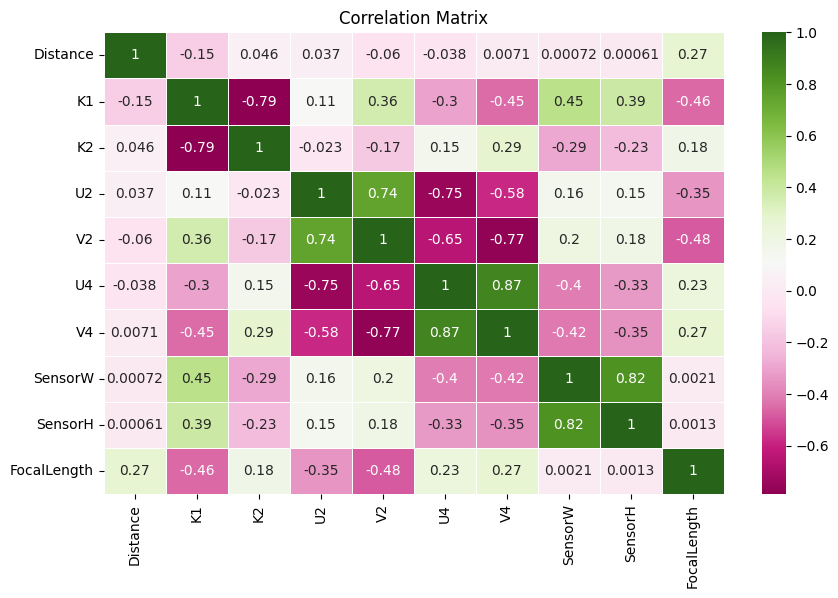

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix to check the relationships between the variables
corr_matrix = training_data[['Distance', 'K1', 'K2', 'U2', 'V2', 'U4', 'V4', 'SensorW', 'SensorH', 'FocalLength']].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='PiYG', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Predict sensor

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

# Load the dataset
file_path = output_csv_path
data = pd.read_csv(file_path)

# Defining features and targets
features = data[['Distance', 'K1', 'K2', 'FocalLength', 'U2', 'V2', 'U4', 'V4', 'PixelWidth', 'PixelHeight']]
target_w = data['SensorW']
target_h = data['SensorH']

# Splitting the data into training and testing sets
X_train, X_test, y_train_w, y_test_w = train_test_split(features, target_w, test_size=0.2, random_state=42)
_, _, y_train_h, y_test_h = train_test_split(features, target_h, test_size=0.2, random_state=42)

# Feature selection to prevent overfitting
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold="median")
X_train_selected = selector.fit_transform(X_train, y_train_w)
X_test_selected = selector.transform(X_test)

# Hyperparameter tuning for SensorW
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_w = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_w.fit(X_train_selected, y_train_w)

best_model_w = grid_search_w.best_estimator_

# Evaluate using cross-validation
cv_scores_w = cross_val_score(best_model_w, X_train_selected, y_train_w, cv=5, scoring='r2')

# Train and predict for SensorW
best_model_w.fit(X_train_selected, y_train_w)
rf_predictions_w = best_model_w.predict(X_test_selected)

# Evaluate SensorW
rf_mse_w = mean_squared_error(y_test_w, rf_predictions_w)
rf_r2_w = r2_score(y_test_w, rf_predictions_w)
rf_mae_w = mean_absolute_error(y_test_w, rf_predictions_w)

# Repeat for SensorH
grid_search_h = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_h.fit(X_train_selected, y_train_h)

best_model_h = grid_search_h.best_estimator_
cv_scores_h = cross_val_score(best_model_h, X_train_selected, y_train_h, cv=5, scoring='r2')

best_model_h.fit(X_train_selected, y_train_h)
rf_predictions_h = best_model_h.predict(X_test_selected)

rf_mse_h = mean_squared_error(y_test_h, rf_predictions_h)
rf_r2_h = r2_score(y_test_h, rf_predictions_h)
rf_mae_h = mean_absolute_error(y_test_h, rf_predictions_h)

# Display evaluation metrics
print(f"SensorW - MSE: {rf_mse_w}, R2: {rf_r2_w}, MAE: {rf_mae_w}, CV R2: {cv_scores_w.mean()}")
print(f"SensorH - MSE: {rf_mse_h}, R2: {rf_r2_h}, MAE: {rf_mae_h}, CV R2: {cv_scores_h.mean()}")

# Plotting predictions vs actual values with metrics
plt.figure(figsize=(14, 6))
plt.suptitle("Random Forest Regressor: Actual vs Predicted", fontsize=16)

# SensorW plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_w, rf_predictions_w, alpha=0.6)
plt.plot([y_test_w.min(), y_test_w.max()], [y_test_w.min(), y_test_w.max()], 'r--')
plt.xlabel('Actual SensorW')
plt.ylabel('Predicted SensorW')
plt.title('Actual vs Predicted SensorW')

# Adding metrics to SensorW plot
plt.text(0.05, 0.95, 
         f"MSE: {rf_mse_w:.2f}\nMAE: {rf_mae_w:.2f}\nR²: {rf_r2_w:.2f}", 
         fontsize=10, 
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# SensorH plot
plt.subplot(1, 2, 2)
plt.scatter(y_test_h, rf_predictions_h, alpha=0.6)
plt.plot([y_test_h.min(), y_test_h.max()], [y_test_h.min(), y_test_h.max()], 'r--')
plt.xlabel('Actual SensorH')
plt.ylabel('Predicted SensorH')
plt.title('Actual vs Predicted SensorH')

# Adding metrics to SensorH plot
plt.text(0.05, 0.95, 
         f"MSE: {rf_mse_h:.2f}\nMAE: {rf_mae_h:.2f}\nR²: {rf_r2_h:.2f}", 
         fontsize=10, 
         transform=plt.gca().transAxes, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import joblib

# Save the trained models
joblib.dump(best_model_w, "sensor_w_model.joblib")
joblib.dump(best_model_h, "sensor_h_model.joblib")

# Save the feature selector
joblib.dump(selector, "feature_selector.joblib")

print("Models and feature selector saved successfully.")


In [ ]:
# Load the models and feature selector
loaded_model_w = joblib.load("sensor_w_model.joblib")
loaded_model_h = joblib.load("sensor_h_model.joblib")
loaded_selector = joblib.load("feature_selector.joblib")

print("Models and feature selector loaded successfully.")

# Example usage with new data
new_data = pd.DataFrame({
    'Distance': [50],
    'K1': [0.1],
    'K2': [-0.2],
    'FocalLength': [35],
    'U2': [0.05],
    'V2': [0.1],
    'U4': [0.02],
    'V4': [0.03],
    'PixelWidth': [1920],
    'PixelHeight': [1080]
})

# Transform the new data using the loaded feature selector
new_data_selected = loaded_selector.transform(new_data)

# Predict SensorW and SensorH using the loaded models
predicted_sensor_w = loaded_model_w.predict(new_data_selected)
predicted_sensor_h = loaded_model_h.predict(new_data_selected)

# Display predictions
print(f"Predicted SensorW: {predicted_sensor_w[0]}")
print(f"Predicted SensorH: {predicted_sensor_h[0]}")


# Train, save and plot

In [28]:
# Remove these lenses because they have insufficient data
lenses_to_remove = ['ZEISS_Supreme_040mm', 'ZEISS_Supreme_065mm']

# Filter out the lenses from the training data
training_data = training_data[~training_data['LensName'].isin(lenses_to_remove)]

In [29]:
from onnxmltools.convert.common.data_types import FloatTensorType
from onnxmltools.convert import convert_xgboost

def save_xgboost_to_onnx(k1_model, k2_model, model_path, input_shape):
    """
    Convert separate XGBoost models for K1 and K2 to ONNX format and save them to disk.

    Parameters:
    - k1_model: The trained XGBoost model for K1.
    - k2_model: The trained XGBoost model for K2.
    - model_path: Path to save the ONNX model. Separate files will be created for each target.
    - input_shape: Number of features in the input data (integer).
    """
    if not isinstance(input_shape, int) or input_shape <= 0:
        raise ValueError(f"Invalid input_shape: {input_shape}. It must be a positive integer.")

    try:
        # Ensure feature names are compatible with ONNX format
        feature_names = [f"f{i}" for i in range(input_shape)]
        
        # Save K1 model
        k1_model.get_booster().feature_names = feature_names
        initial_type = [('float_input', FloatTensorType([None, input_shape]))]
        onnx_k1 = convert_xgboost(k1_model, initial_types=initial_type)
        k1_model_path = model_path.with_stem(model_path.stem + "_k1")
        with open(k1_model_path, "wb") as f:
            f.write(onnx_k1.SerializeToString())
        print(f"K1 ONNX model successfully saved at: {k1_model_path}")
        
        # Save K2 model
        k2_model.get_booster().feature_names = feature_names
        onnx_k2 = convert_xgboost(k2_model, initial_types=initial_type)
        k2_model_path = model_path.with_stem(model_path.stem + "_k2")
        with open(k2_model_path, "wb") as f:
            f.write(onnx_k2.SerializeToString())
        print(f"K2 ONNX model successfully saved at: {k2_model_path}")
    
    except Exception as e:
        print(f"Failed to convert XGBoost models to ONNX: {e}")
        raise


In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def train_separate_models_with_search(training_data):
    """
    Train separate XGBoost models for K1 and K2 with parameter search.

    Args:
        training_data (pd.DataFrame): DataFrame containing the features and targets.
            Expected columns: 'SensorW', 'SensorH', 'Distance', 'PixelWidth', 'PixelHeight', 'K1', 'K2'.

    Returns:
        tuple: Best XGBoost models for K1 and K2, predictions, and test data (actual values).
    """
    # Rename features for compatibility
    feature_columns = ['SensorW', 'SensorH', 'Distance']
    renamed_features = {col: f"f{i}" for i, col in enumerate(feature_columns)}
    training_data = training_data.rename(columns=renamed_features)
    
    # Define features and targets
    features = training_data[list(renamed_features.values())]
    targets = training_data[['K1', 'K2']]
    
    # Split data into train-test
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    
    # Define parameter grid for search
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_child_weight': [3, 5, 7],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'reg_alpha': [0, 0.1, .5],
        'reg_lambda': [1, 1.5, 2]
    }
    
    def train_with_search(X_train, y_train, param_grid):
        model = xgb.XGBRegressor(eval_metric='rmse', random_state=42)
        grid_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            scoring='neg_root_mean_squared_error',
            n_iter=10,
            cv=3,
            verbose=1,
            random_state=42,
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_

    print("Training model for K1 with parameter search...")
    best_k1_model = train_with_search(X_train, y_train['K1'], param_grid)

    print("\nTraining model for K2 with parameter search...")
    best_k2_model = train_with_search(X_train, y_train['K2'], param_grid)
    
    # Make predictions
    predictions_k1 = best_k1_model.predict(X_test)
    predictions_k2 = best_k2_model.predict(X_test)
    
    # Combine predictions
    predictions = np.column_stack((predictions_k1, predictions_k2))
    
    return best_k1_model, best_k2_model, predictions, y_test


In [ ]:
# Get all unique lens names
lens_names = training_data['LensName'].unique()

# Process specific lens for testing
#lens_names = ['ARRI-ZEISS_Master_100mm']
#lens_names = ['ARRIFLEX-ZEISS_MK_085mm']


# Store results for all lenses
lens_results = []

# Train and save models for each lens
for lens in lens_names:
    #lens_data = training_data[training_data['LensName'] == lens]
    lens_data = training_data[(training_data['LensName'] == lens) & (training_data['CameraName'] != 'Alexa35_3.3k_6x5')]

    
    # Train separate models for K1 and K2
    print(f"Training models for lens: {lens}")
    k1_model, k2_model, predictions, y_test = train_separate_models_with_search(lens_data)
    
    # Save the models to ONNX
    model_dir.mkdir(parents=True, exist_ok=True)  # Ensure the model directory exists
    save_xgboost_to_onnx(
        k1_model=k1_model,
        k2_model=k2_model,
        model_path=model_dir / f"{lens}_model.onnx",
        input_shape=3
    )
    
    # Store results for plotting
    lens_results.append((lens, y_test, predictions))


In [32]:
def plot_results(y_test, predictions, lens_name, r2_threshold=None):
    """
    Plot predictions vs actual values for K1 and K2.

    Args:
        y_test (pd.DataFrame): Actual test values for K1 and K2.
        predictions (np.ndarray): Predicted values for K1 and K2.
        lens_name (str): Name of the lens to include in plot titles.
        r2_threshold (float, optional): Plot only if R² < r2_threshold. Defaults to None.
    """
    # Calculate R² for both targets
    r2_values = []
    for idx, target in enumerate(['K1', 'K2']):
        actual = y_test[target]
        pred = predictions[:, idx]
        r2 = r2_score(actual, pred)
        r2_values.append(r2)

    # Skip the entire figure if R² threshold is not met for both targets
    if r2_threshold is not None and all(r2 >= r2_threshold for r2 in r2_values):
        #print(f"Skipping plot: All R² values ({r2_values}) are >= {r2_threshold}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    axes = axes.ravel()

    for idx, (target, label) in enumerate(zip(['K1', 'K2'], ['K1 Predictions', 'K2 Predictions'])):
        actual = y_test[target]
        pred = predictions[:, idx]

        mse = mean_squared_error(actual, pred)
        rmse = mse**0.5
        mae = mean_absolute_error(actual, pred)
        r2 = r2_score(actual, pred)

        # Set background color to dark orange if R² < 0.9
        if r2 < 0.9:
            axes[idx].set_facecolor('#878787')  # Dark orange (color-blind safe)

        dot_color = '#101010' if r2 < 0.9 else '#1D4990'

        # Scatter plot and perfect fit line
        axes[idx].scatter(actual, pred, alpha=0.7, label='Predictions', c=dot_color)
        axes[idx].plot([actual.min(), actual.max()], [actual.min(), actual.max()], color='#A71B5F', lw=2, label='Perfect Fit')
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].set_title(f"{label}\nMSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        axes[idx].legend()
        axes[idx].grid()

    # Add overall title
    plt.suptitle(f"Predictions vs Actuals for Lens: {lens_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

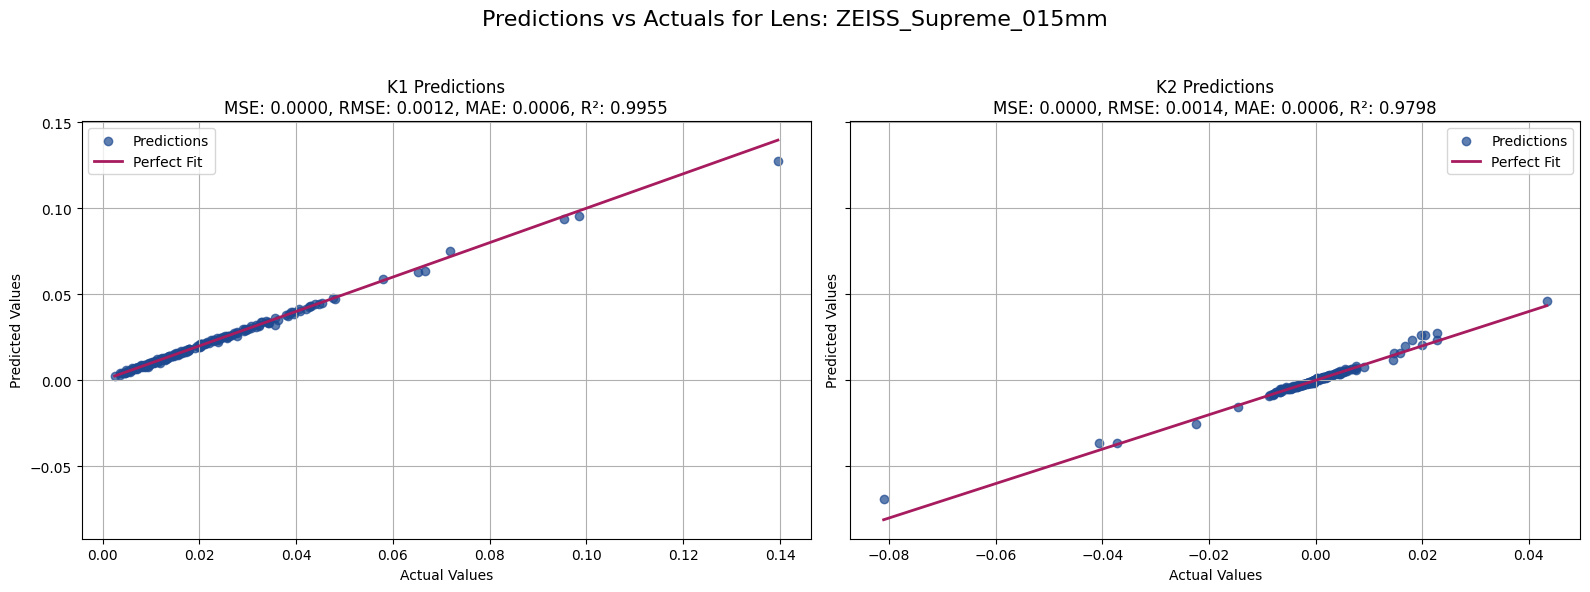

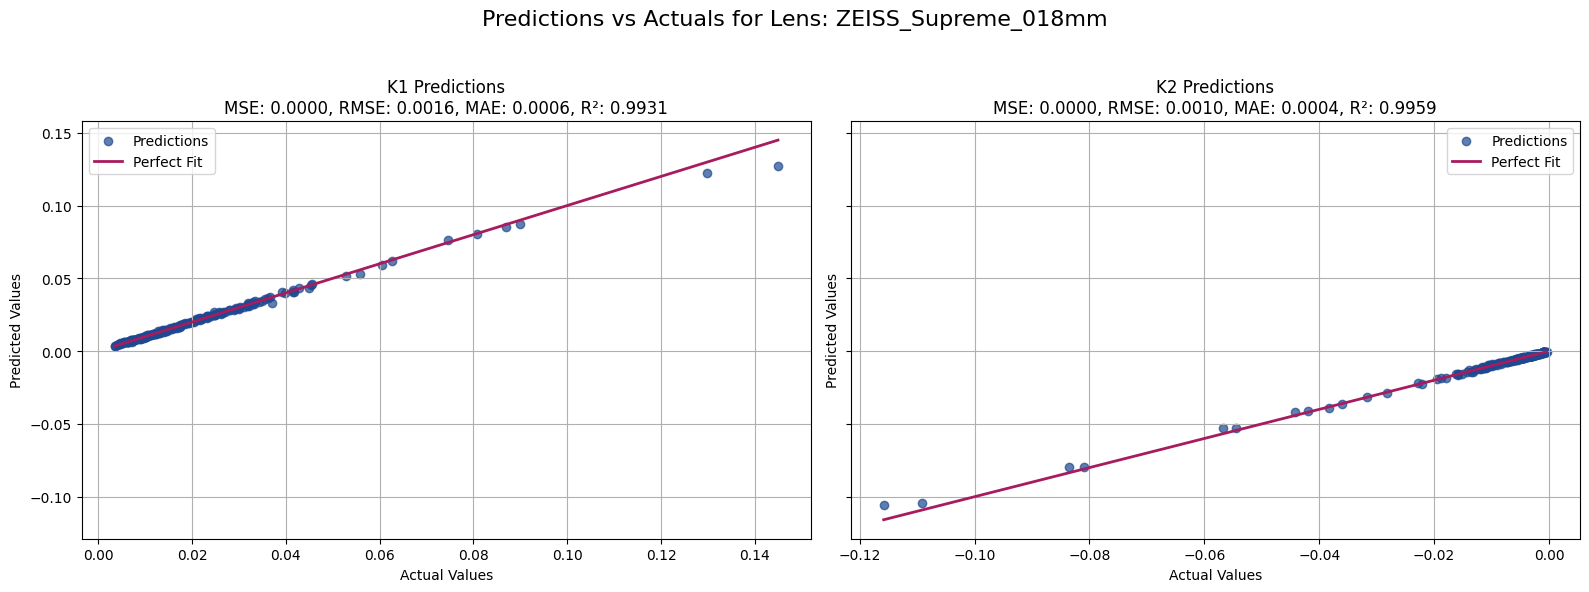

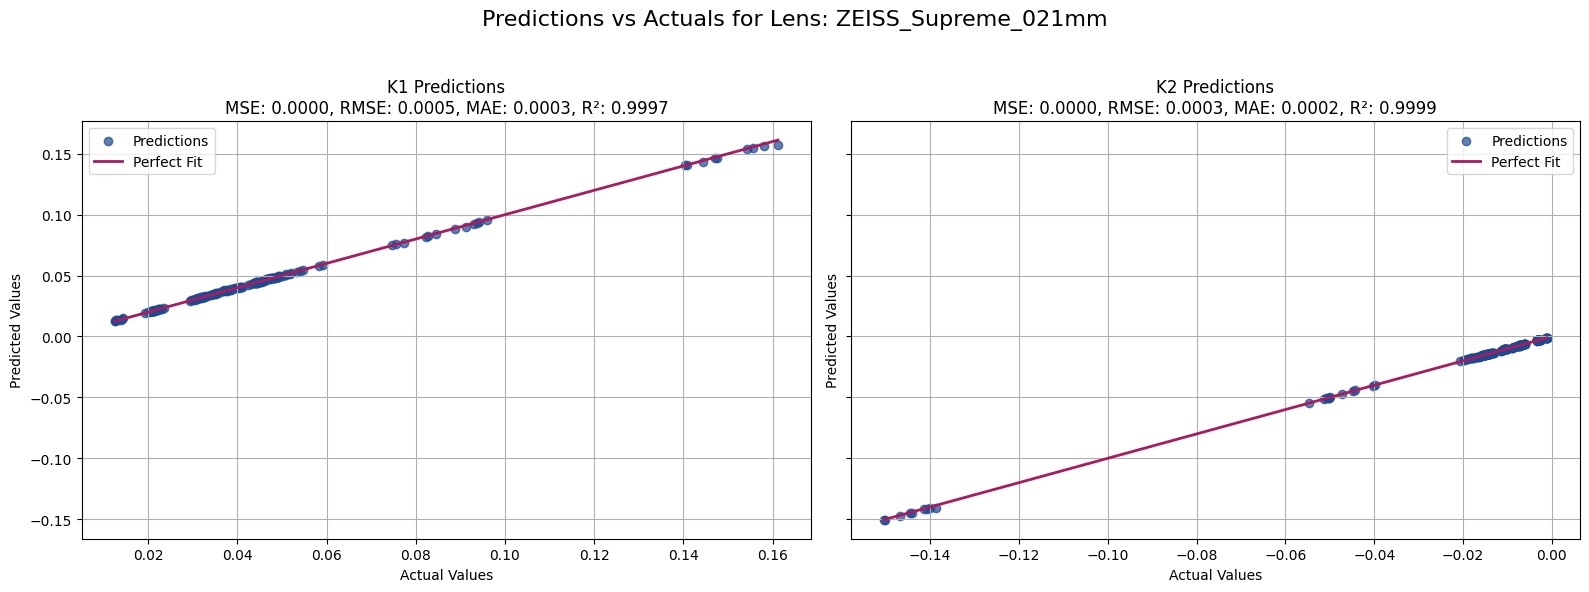

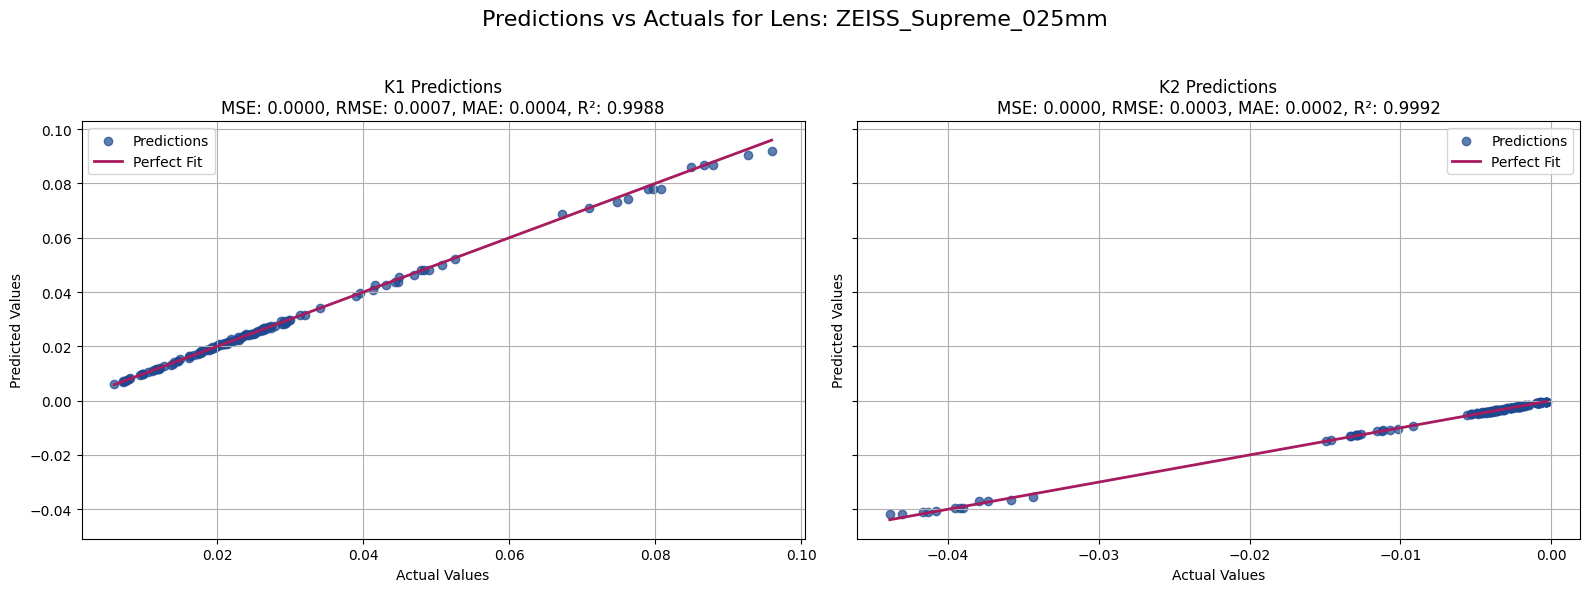

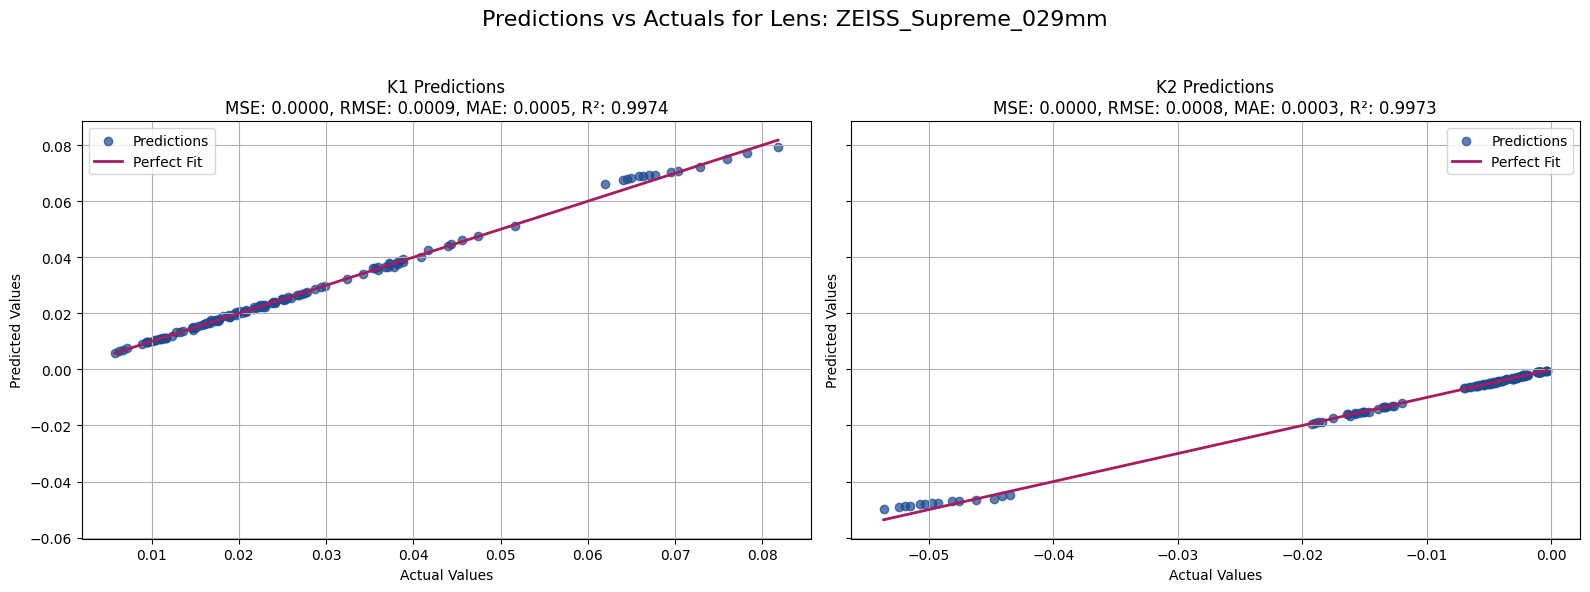

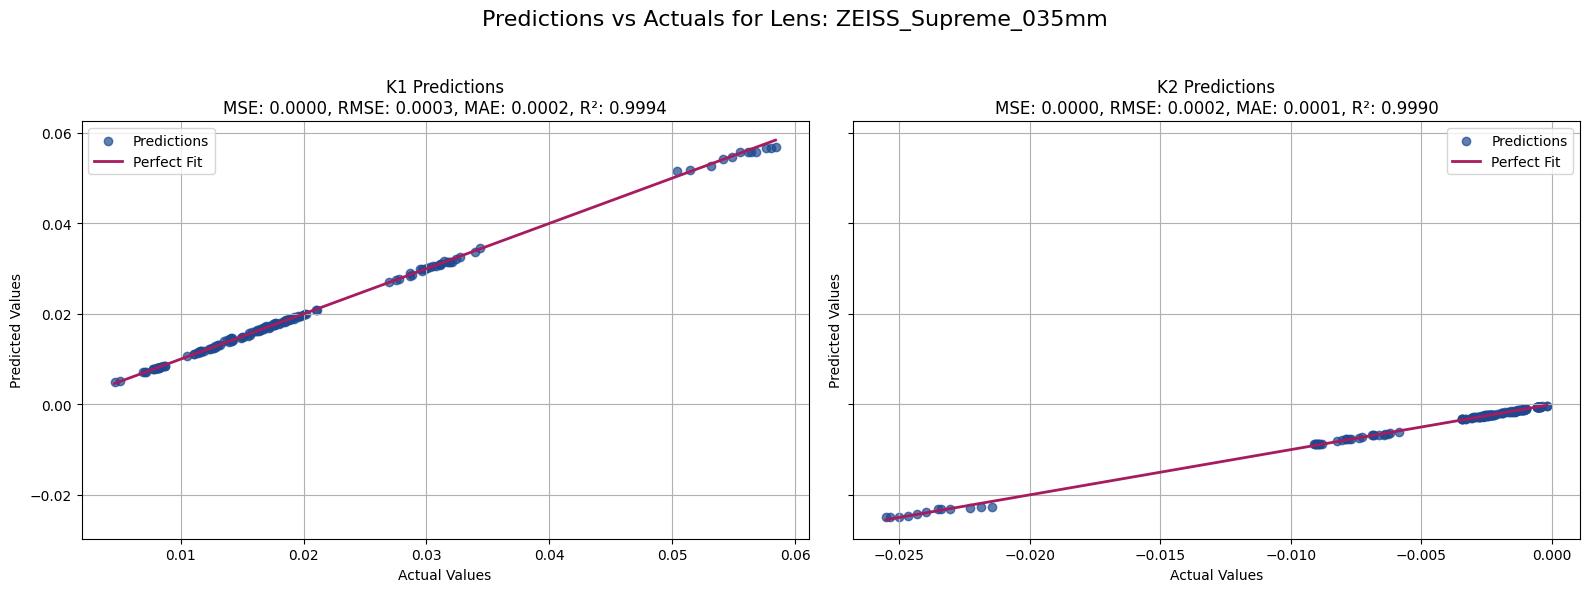

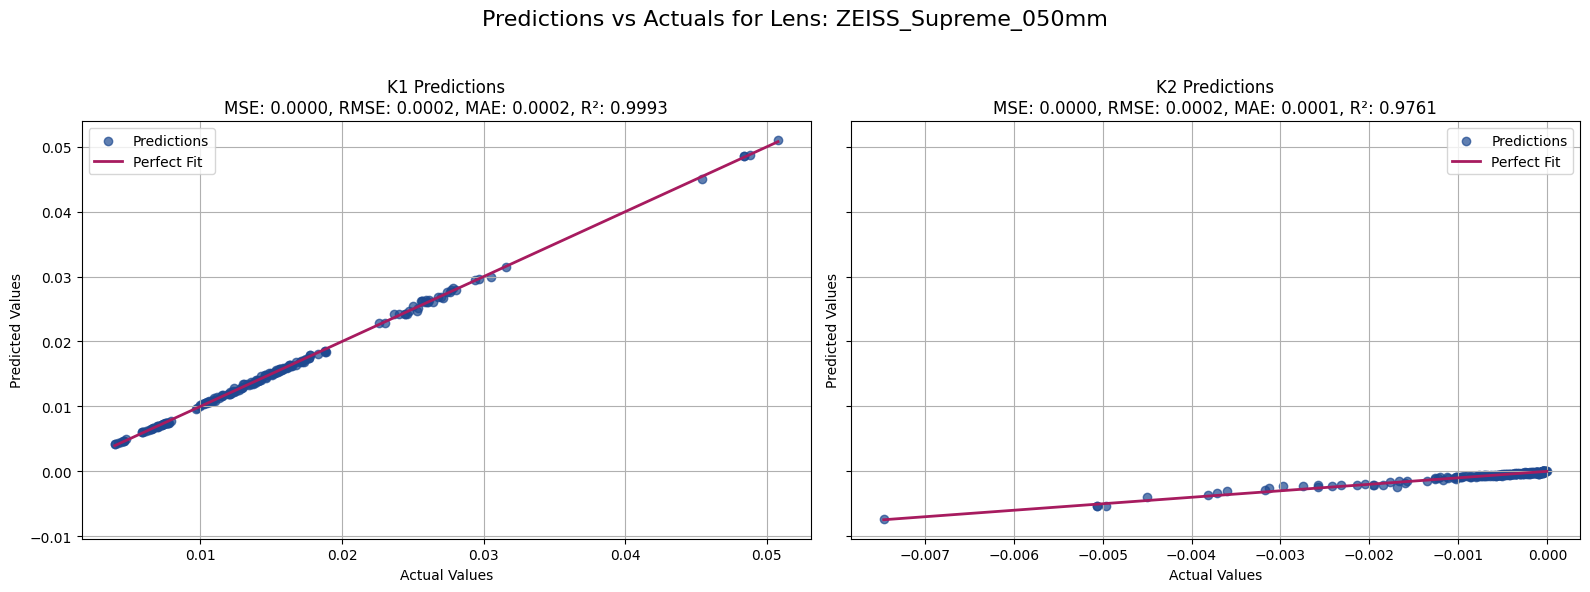

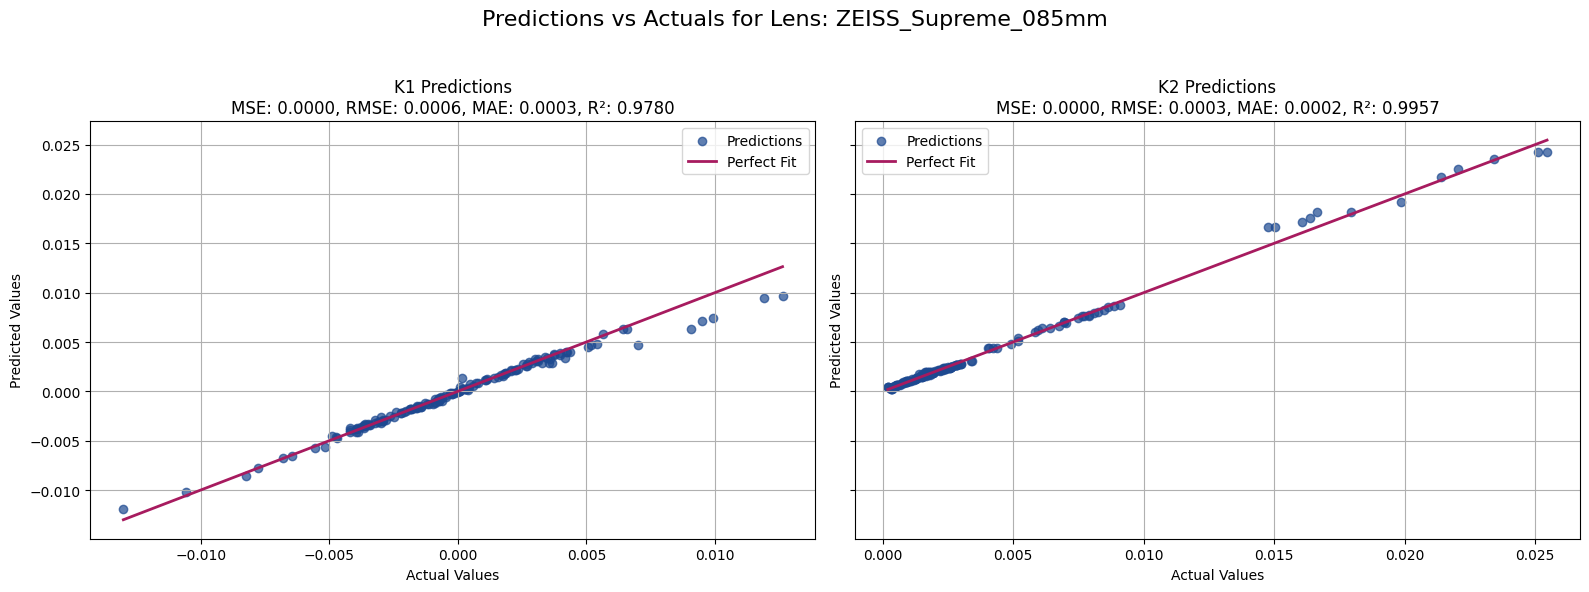

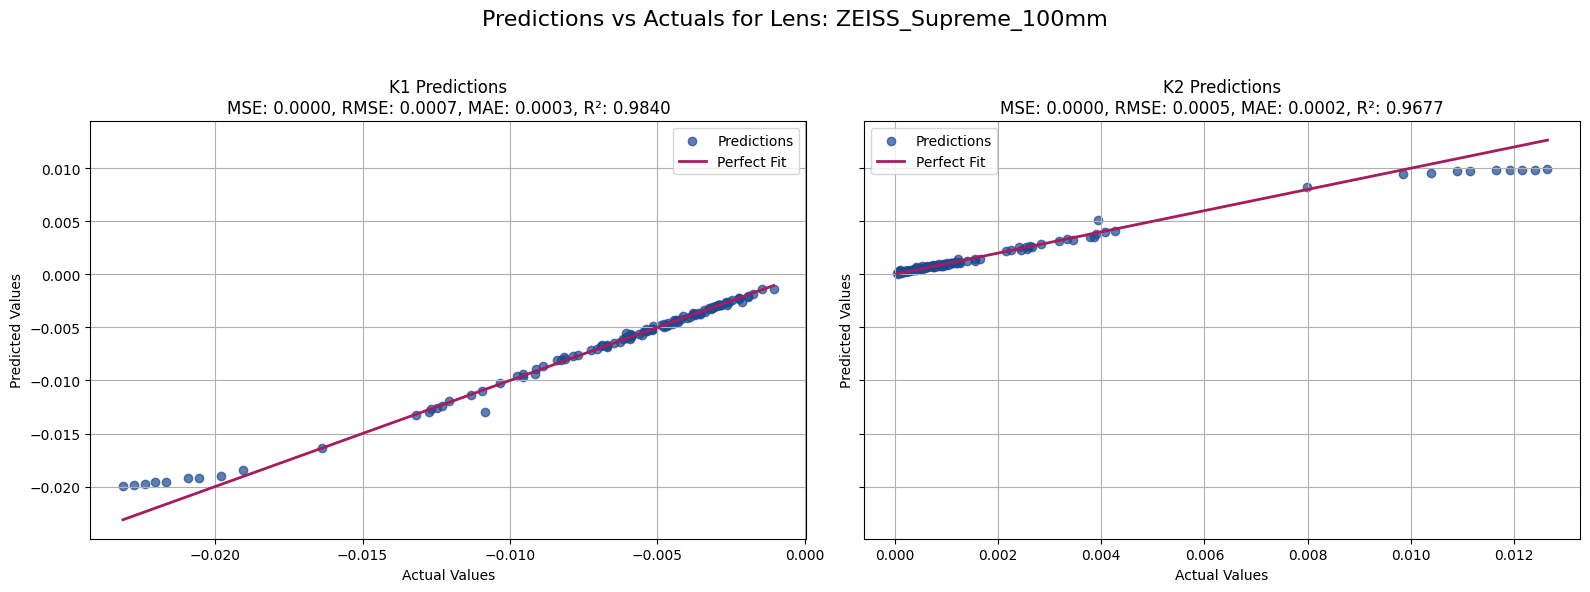

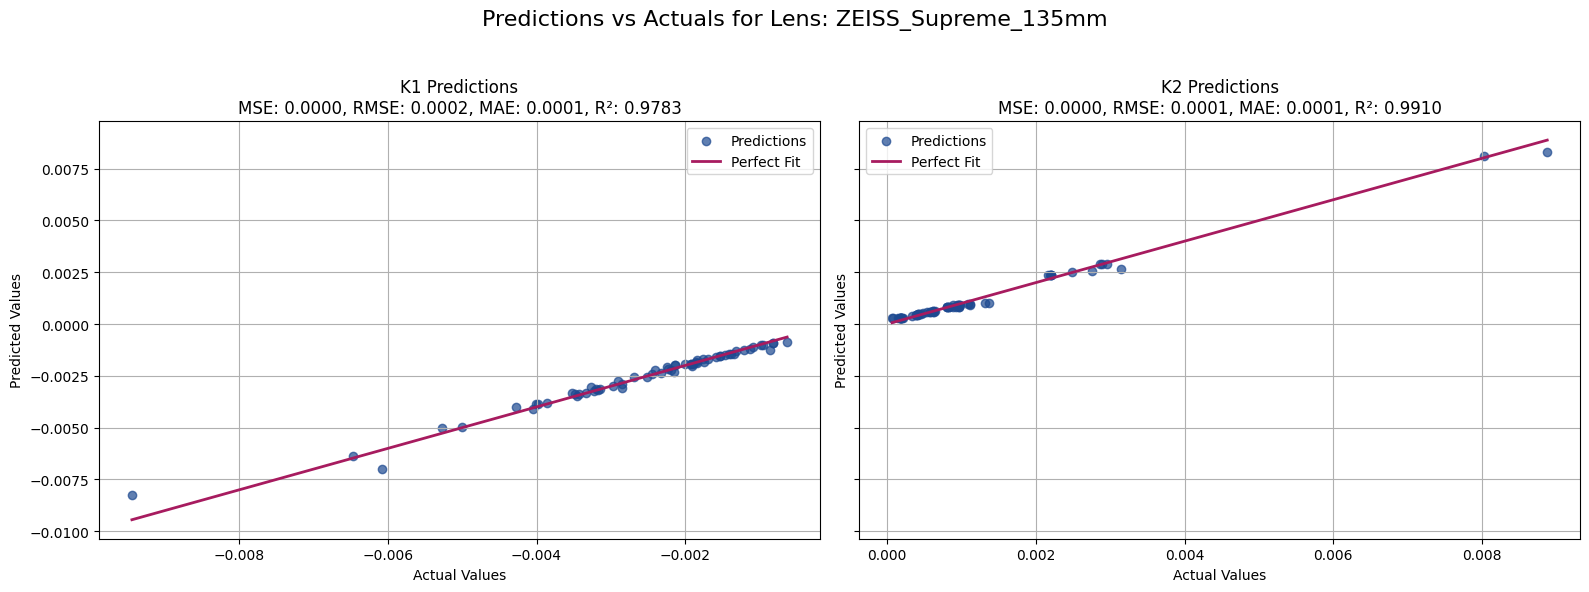

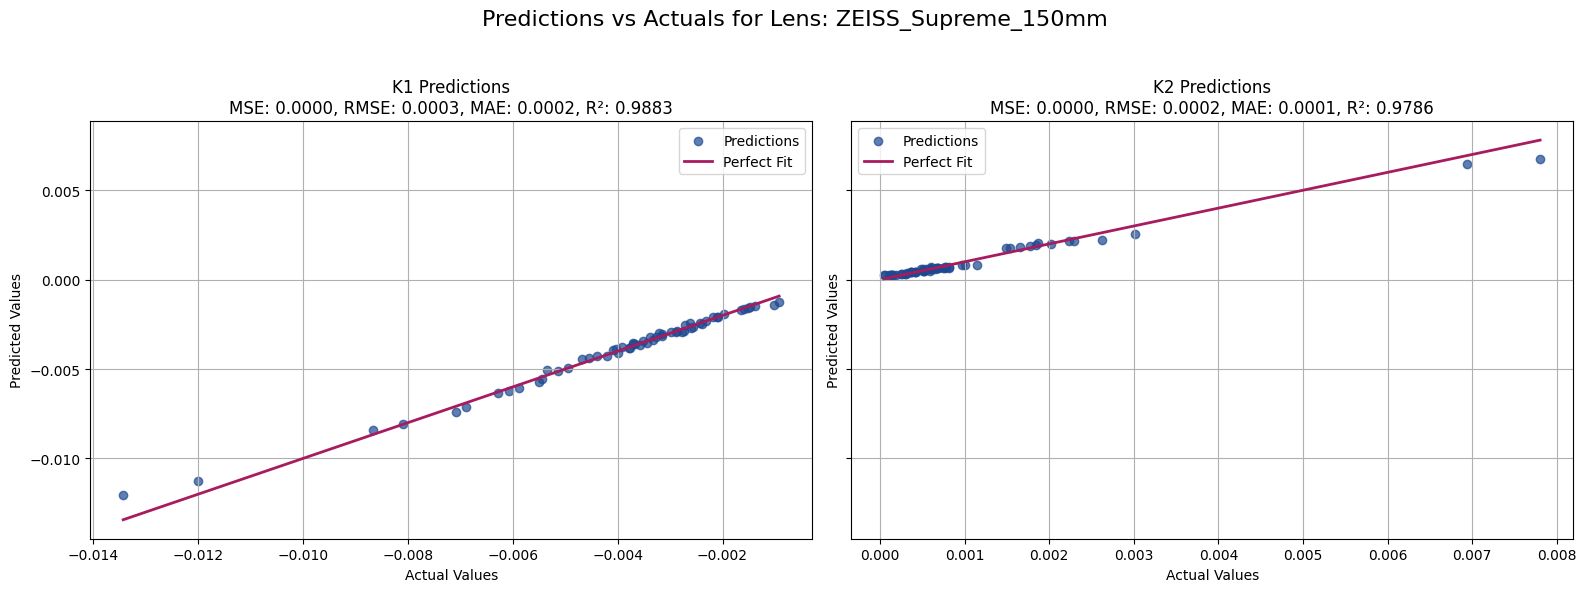

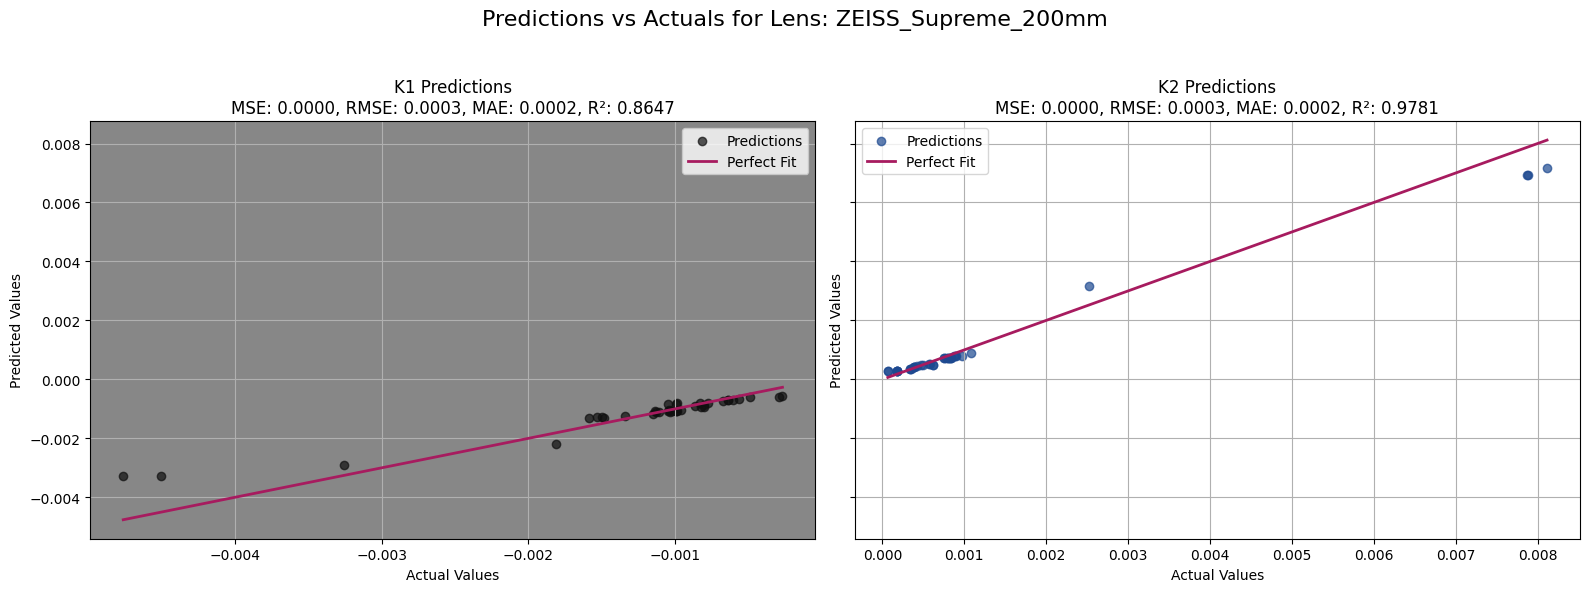

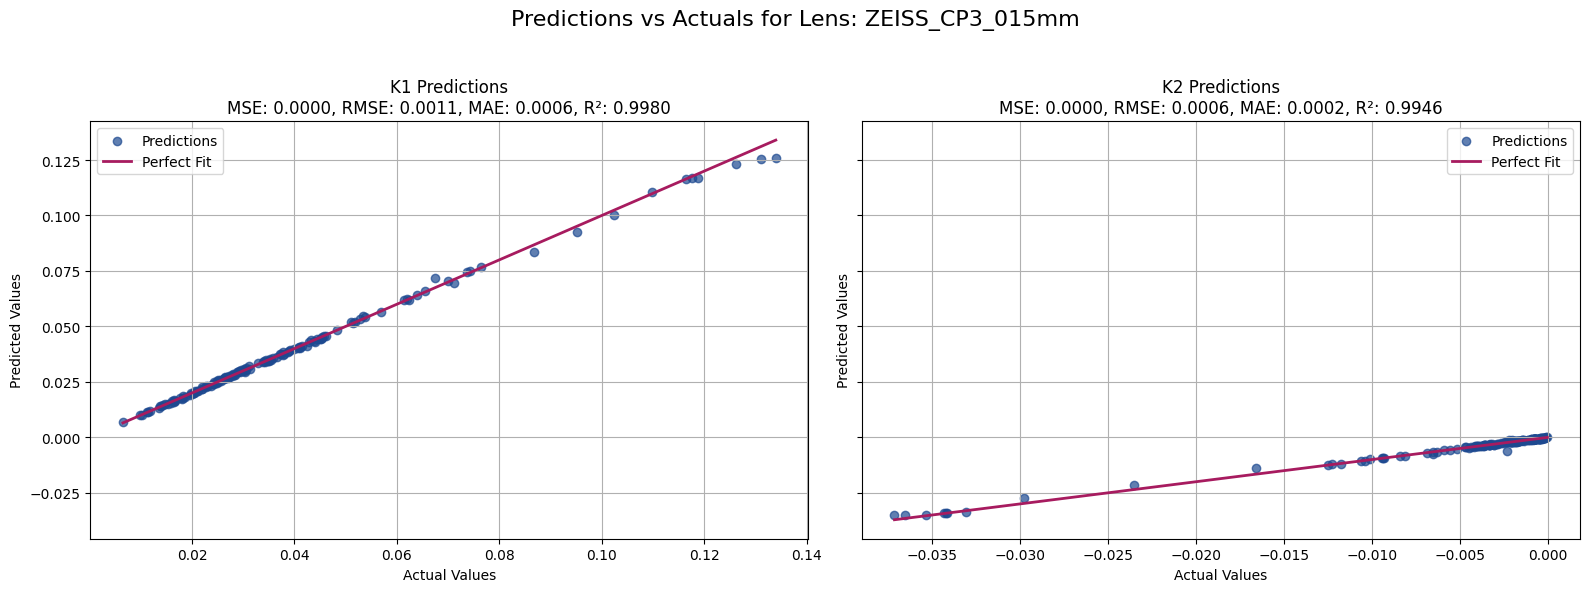

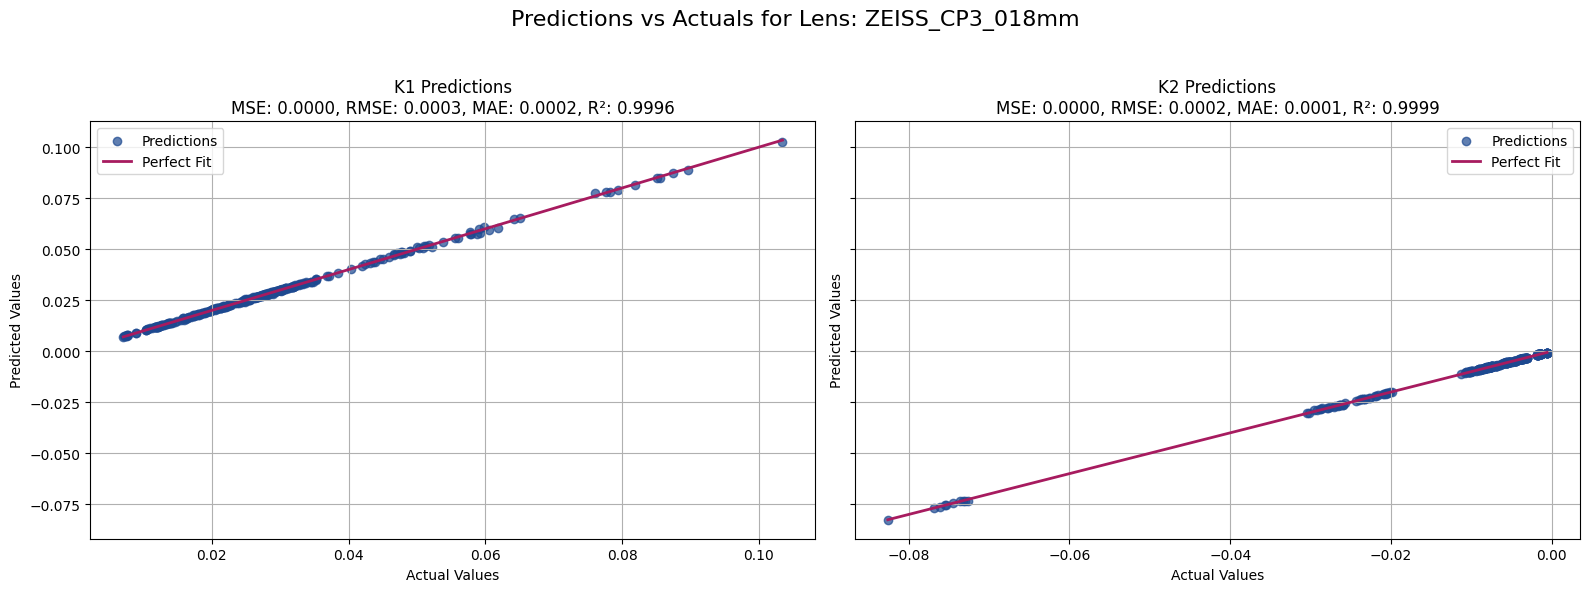

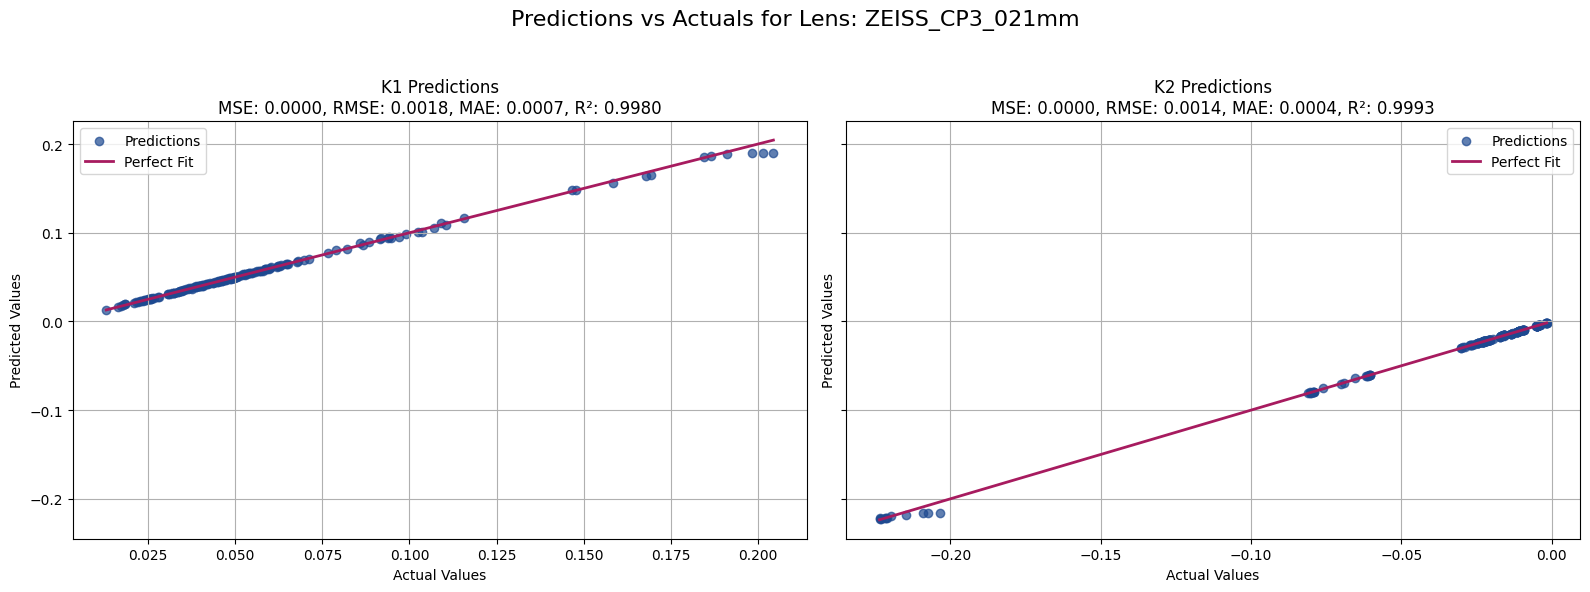

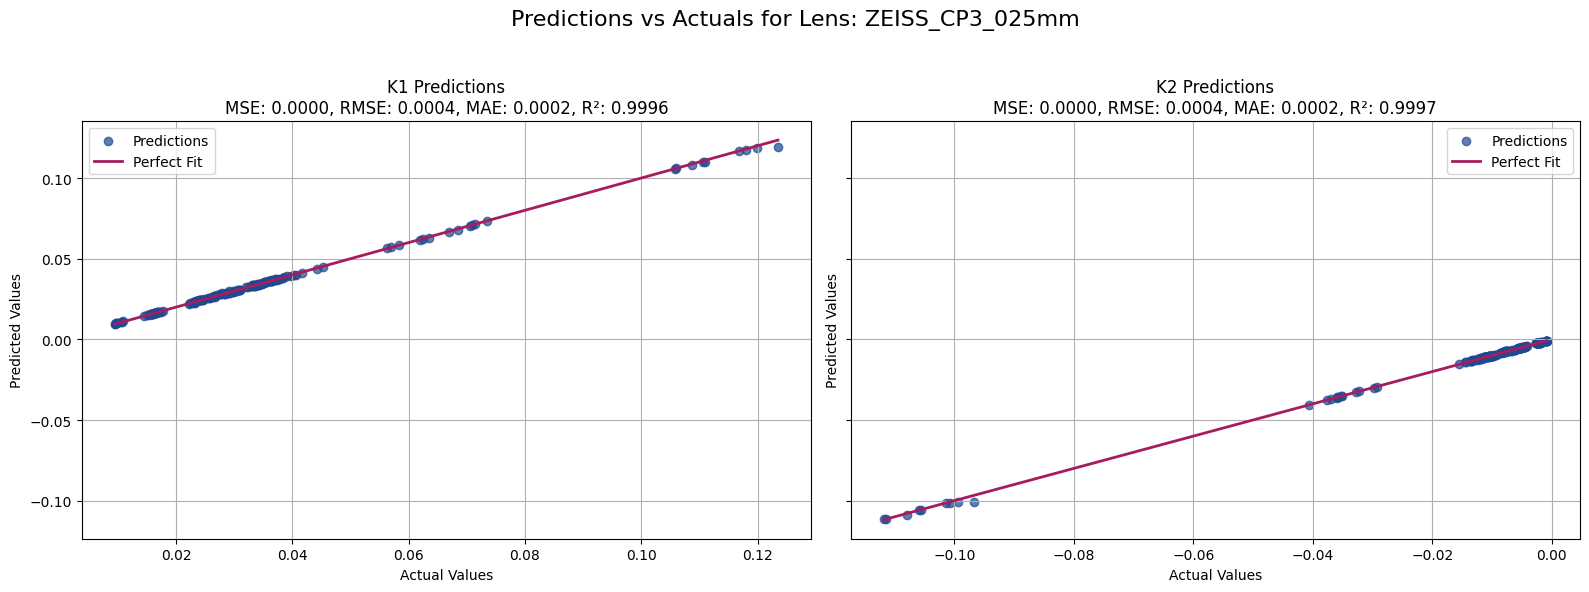

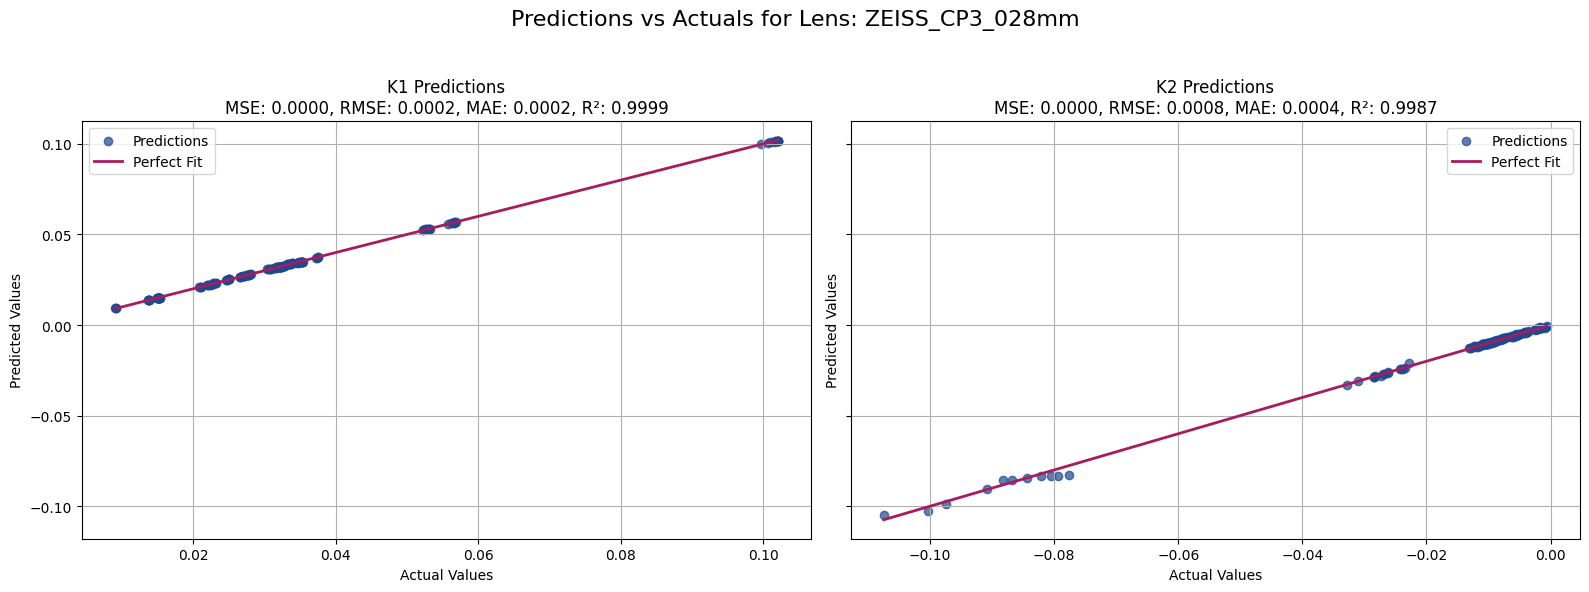

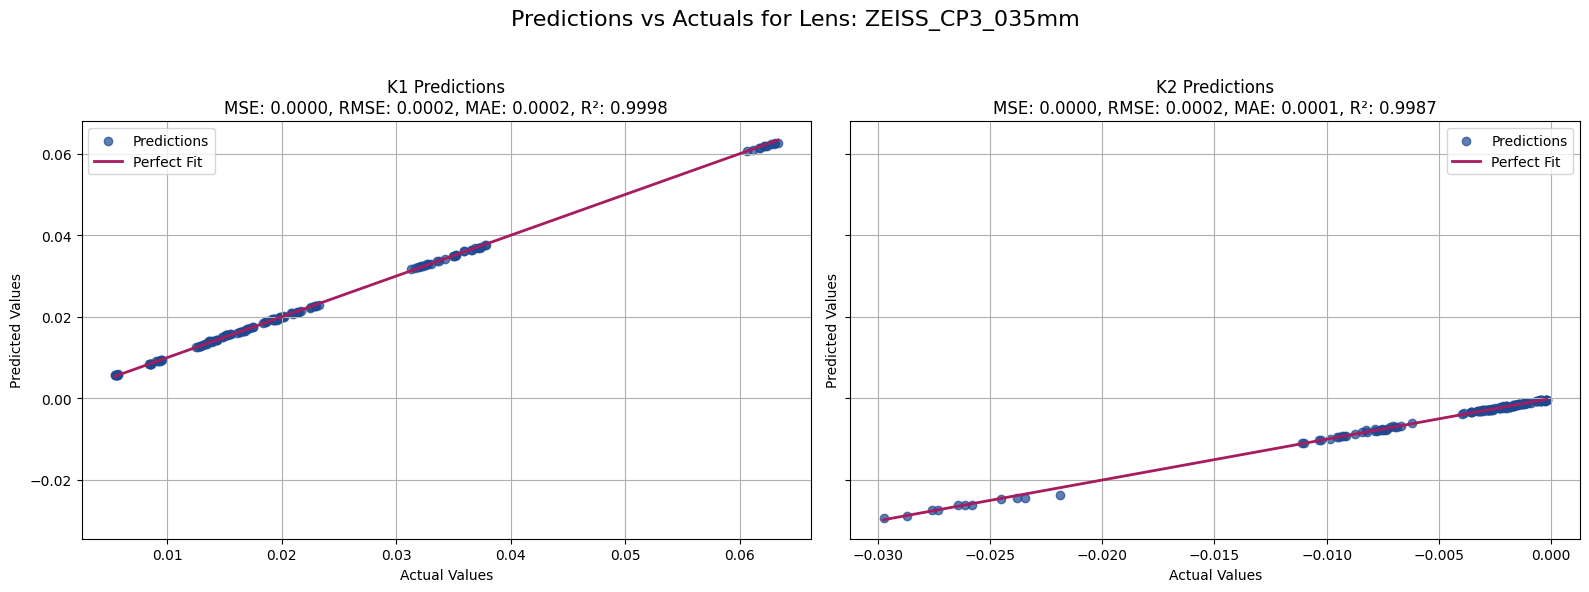

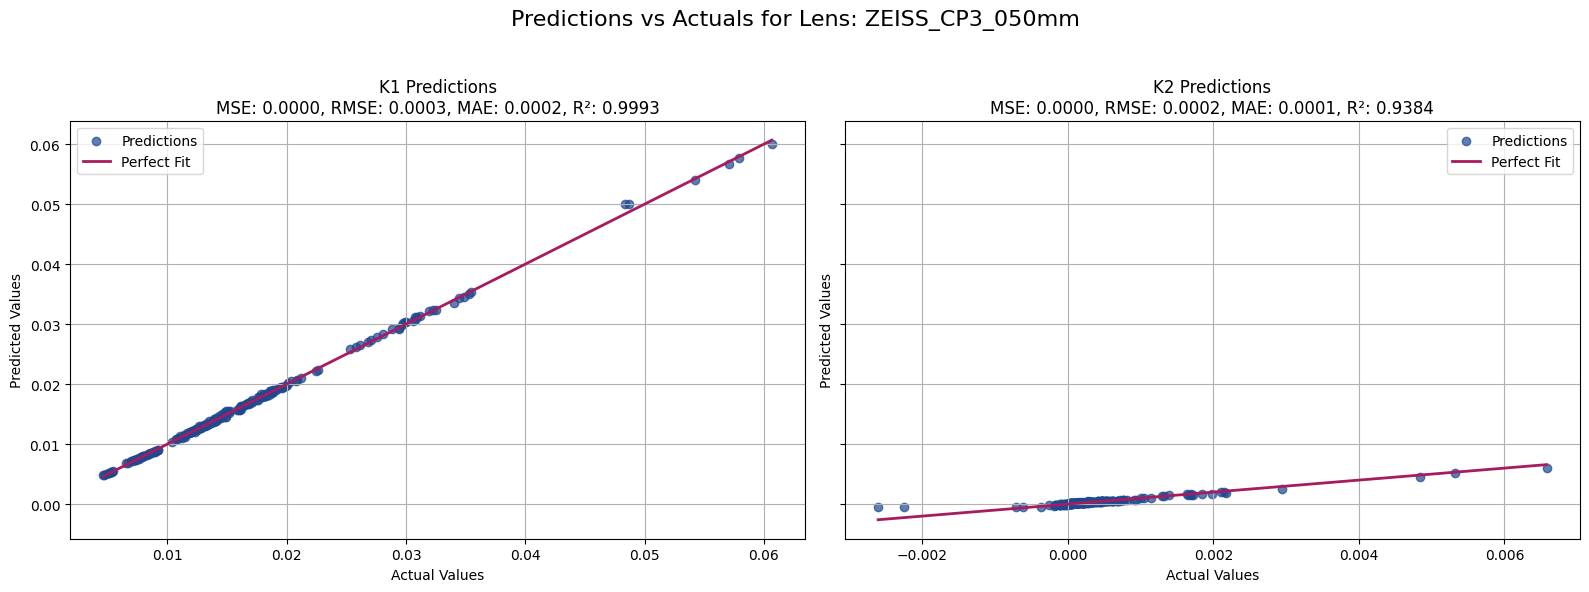

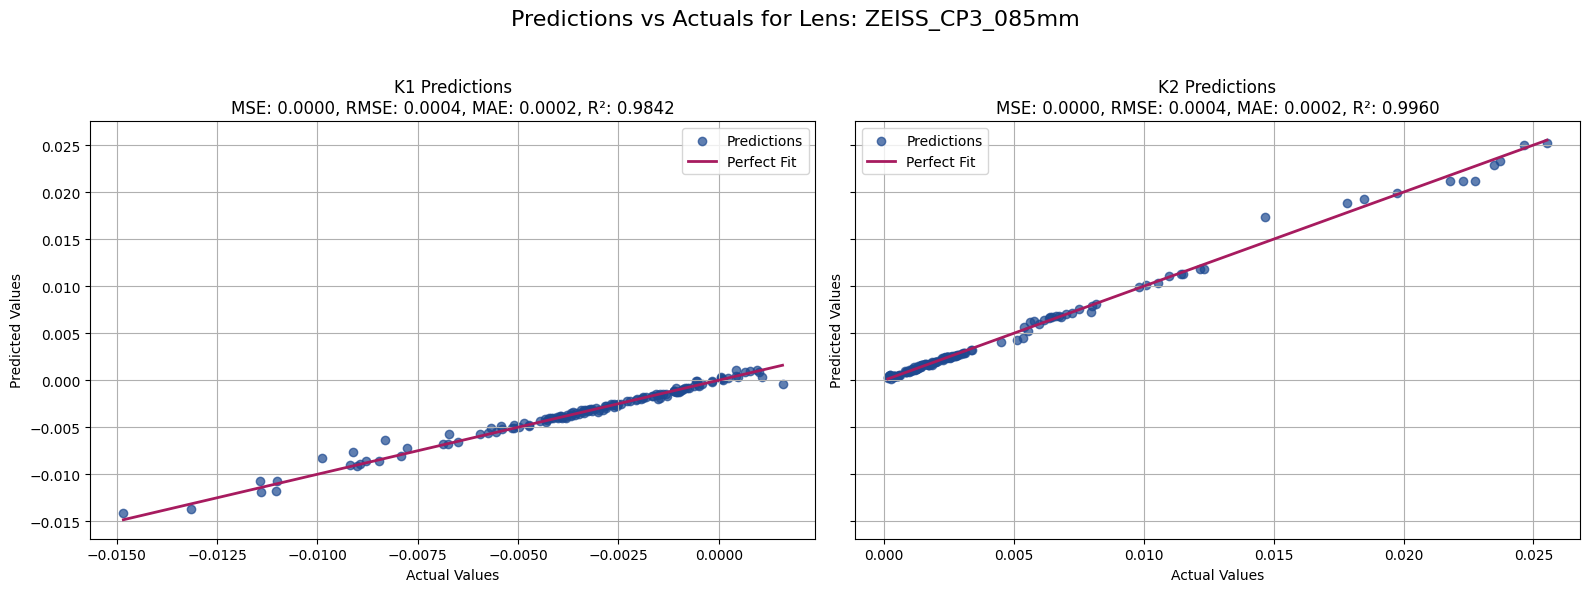

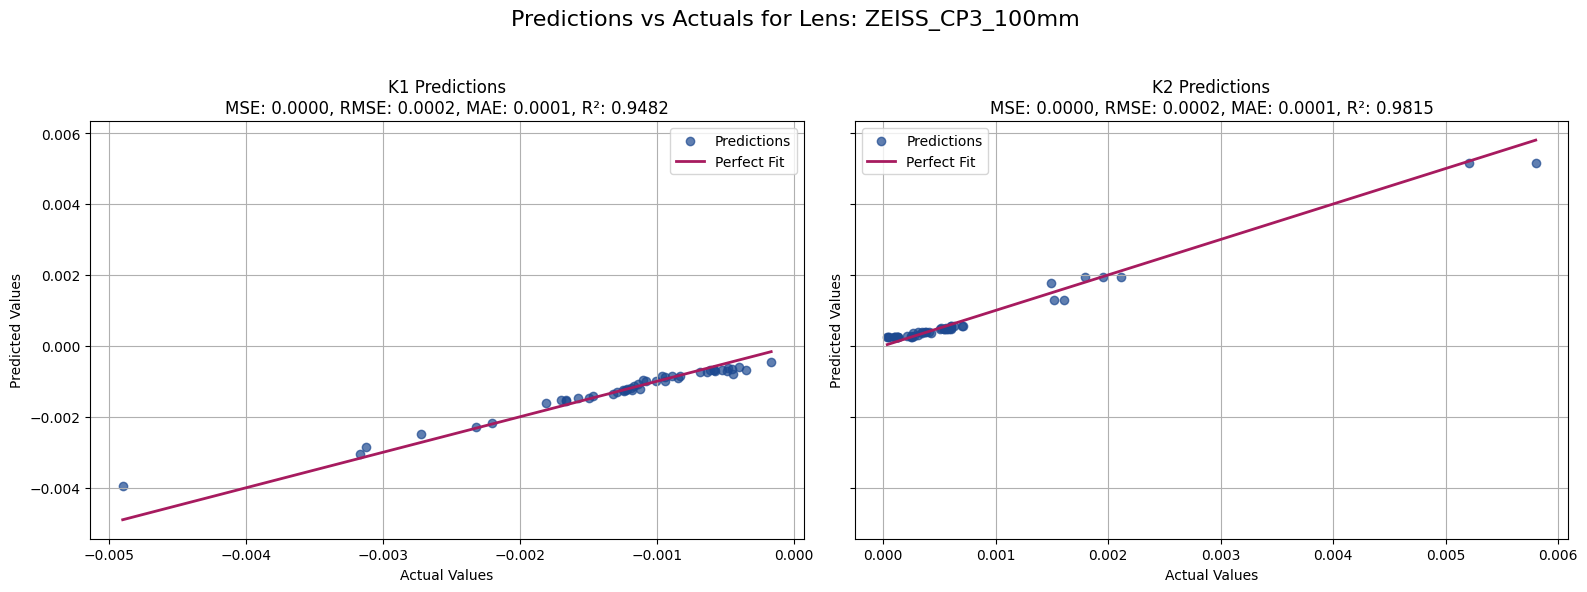

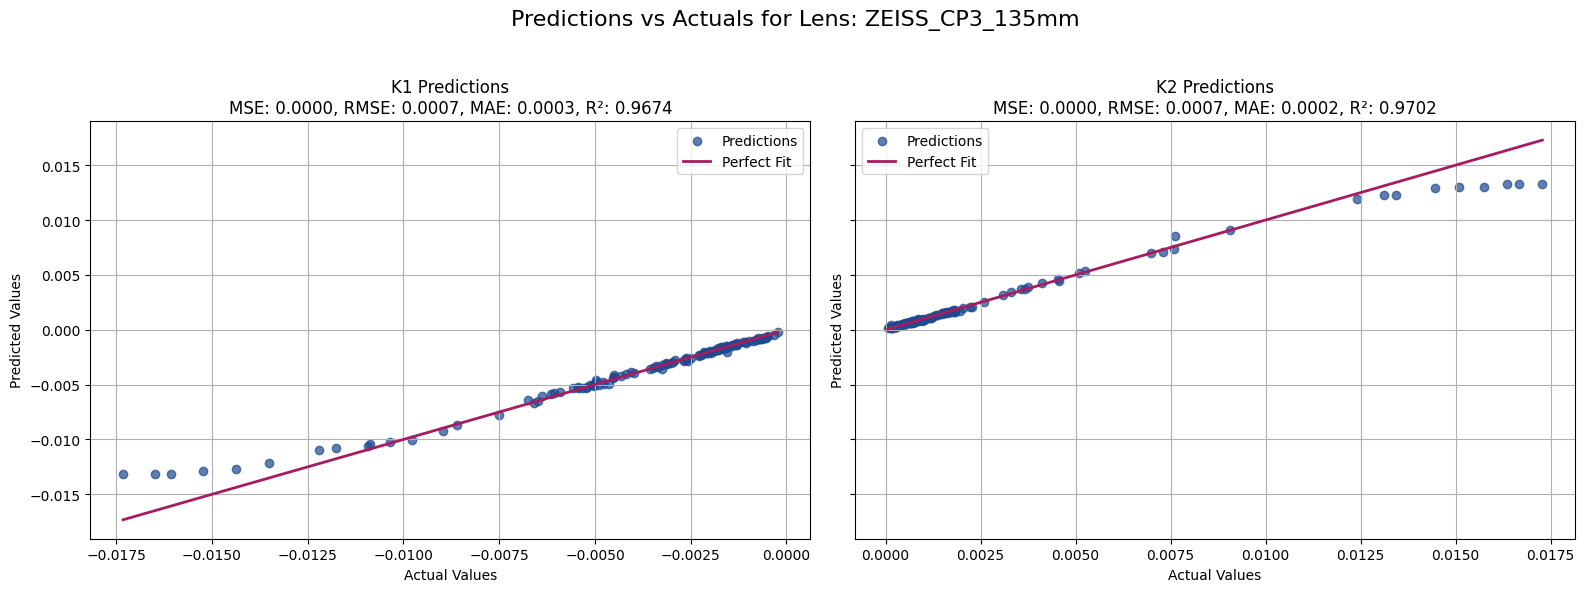

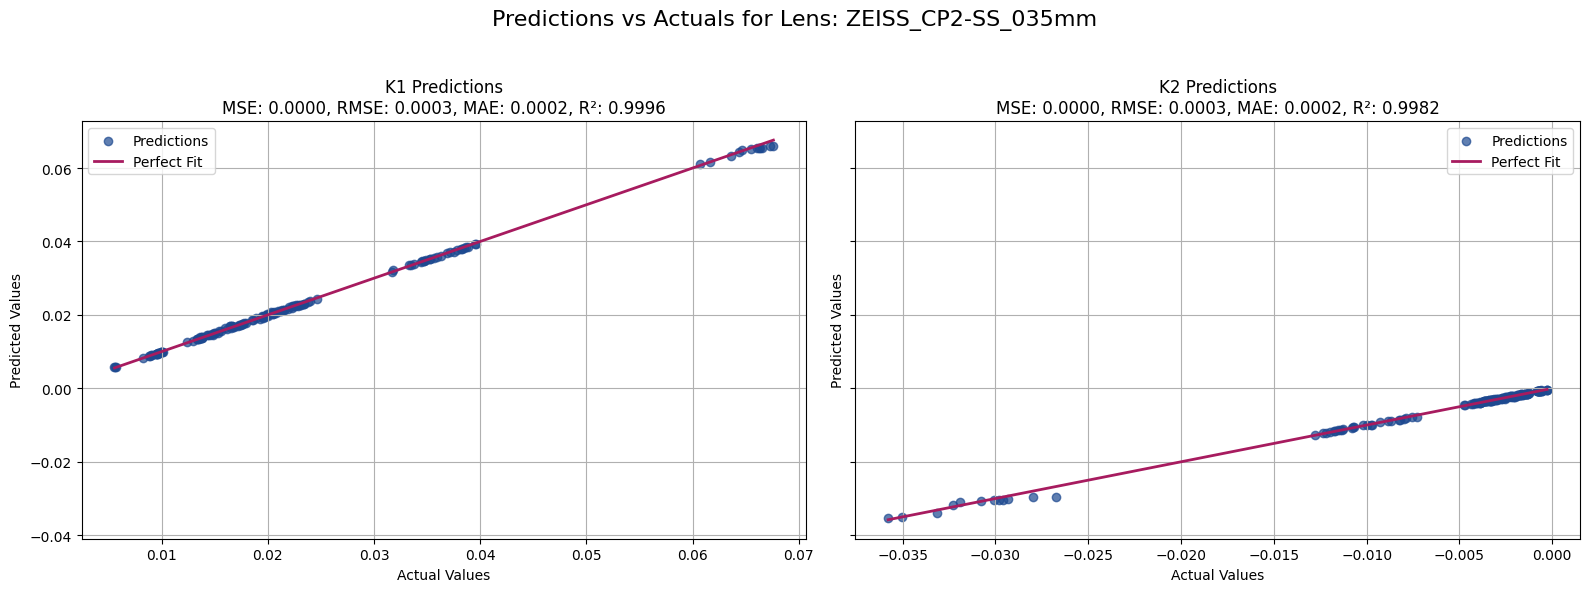

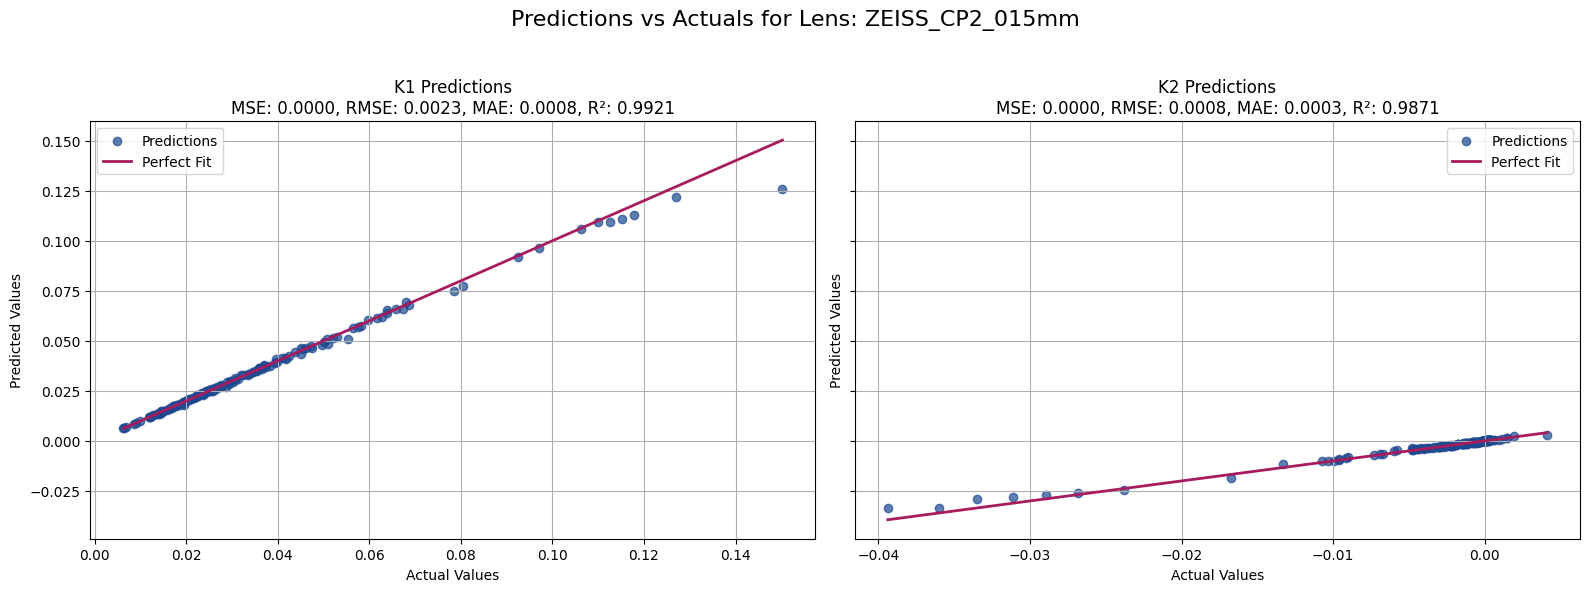

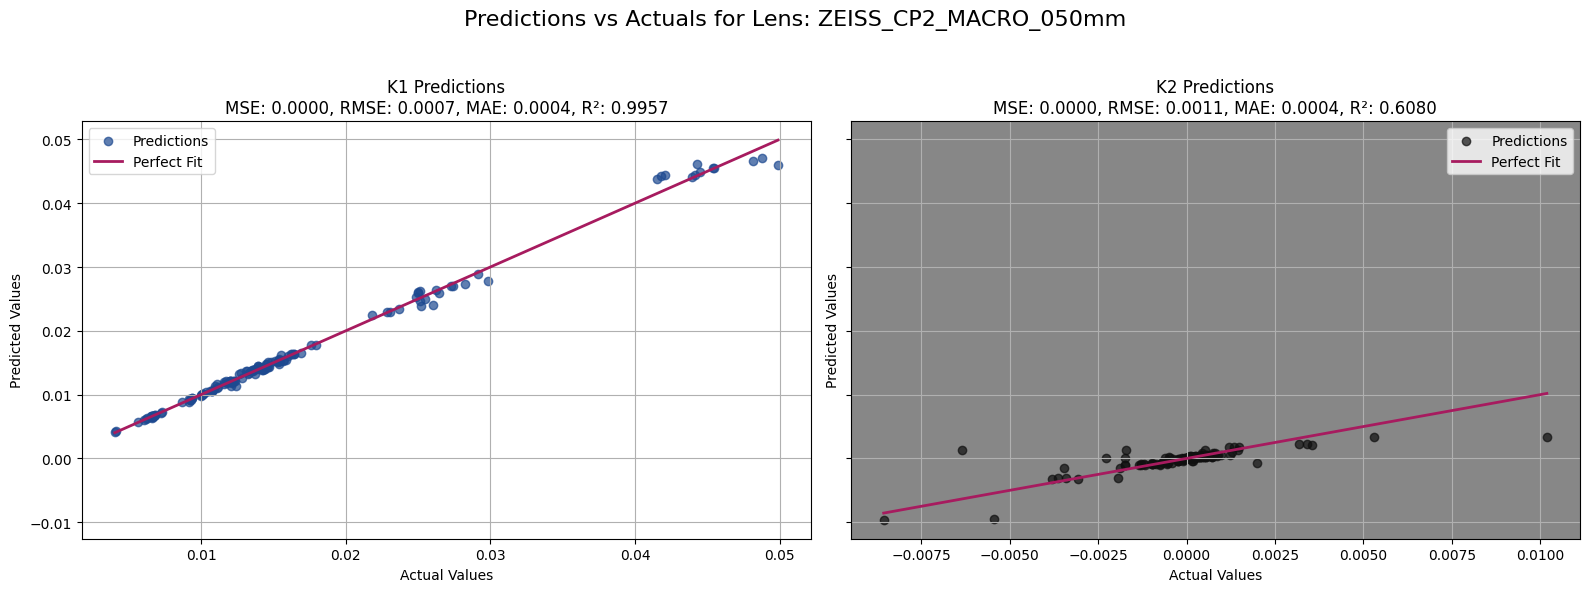

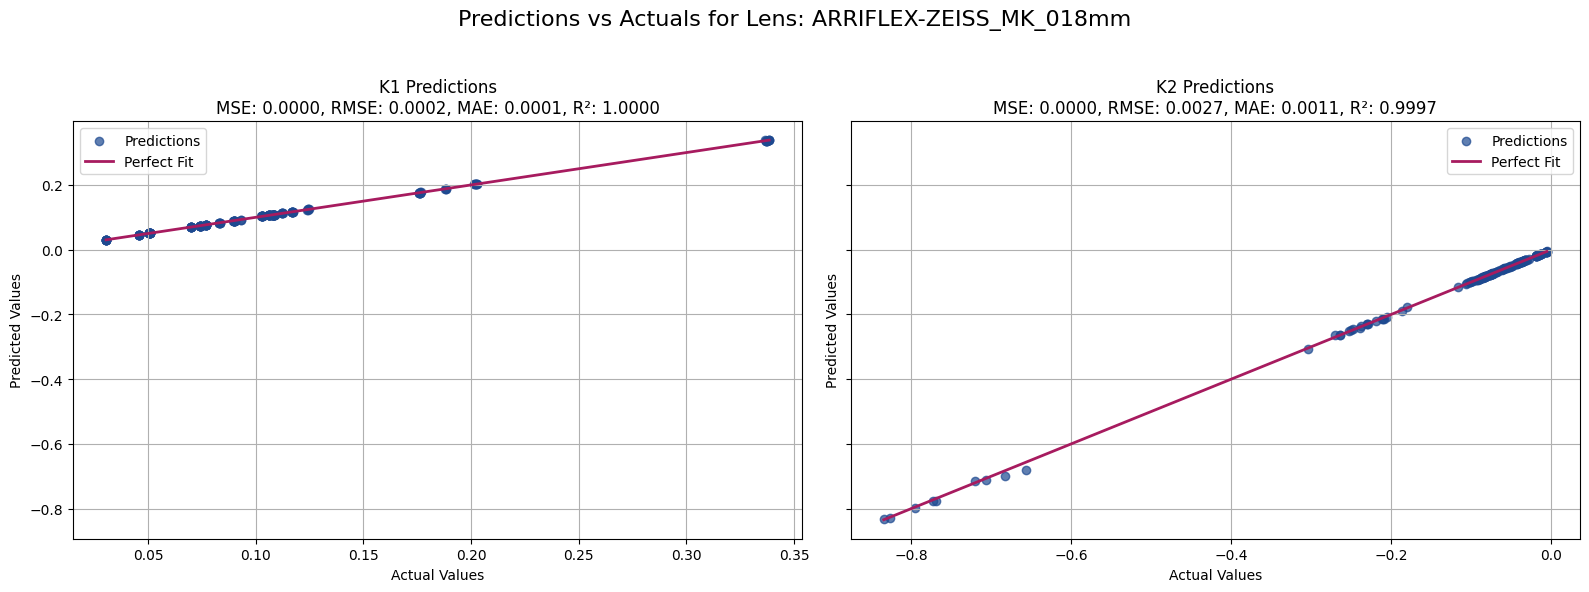

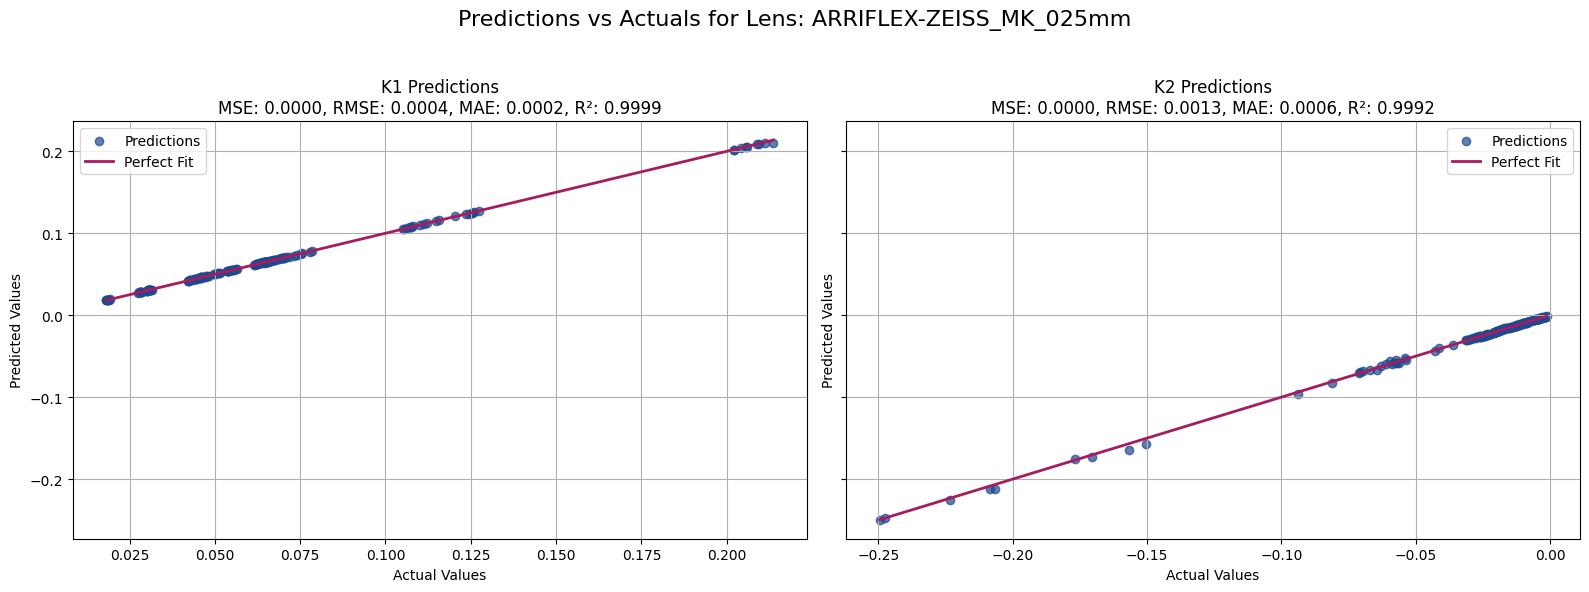

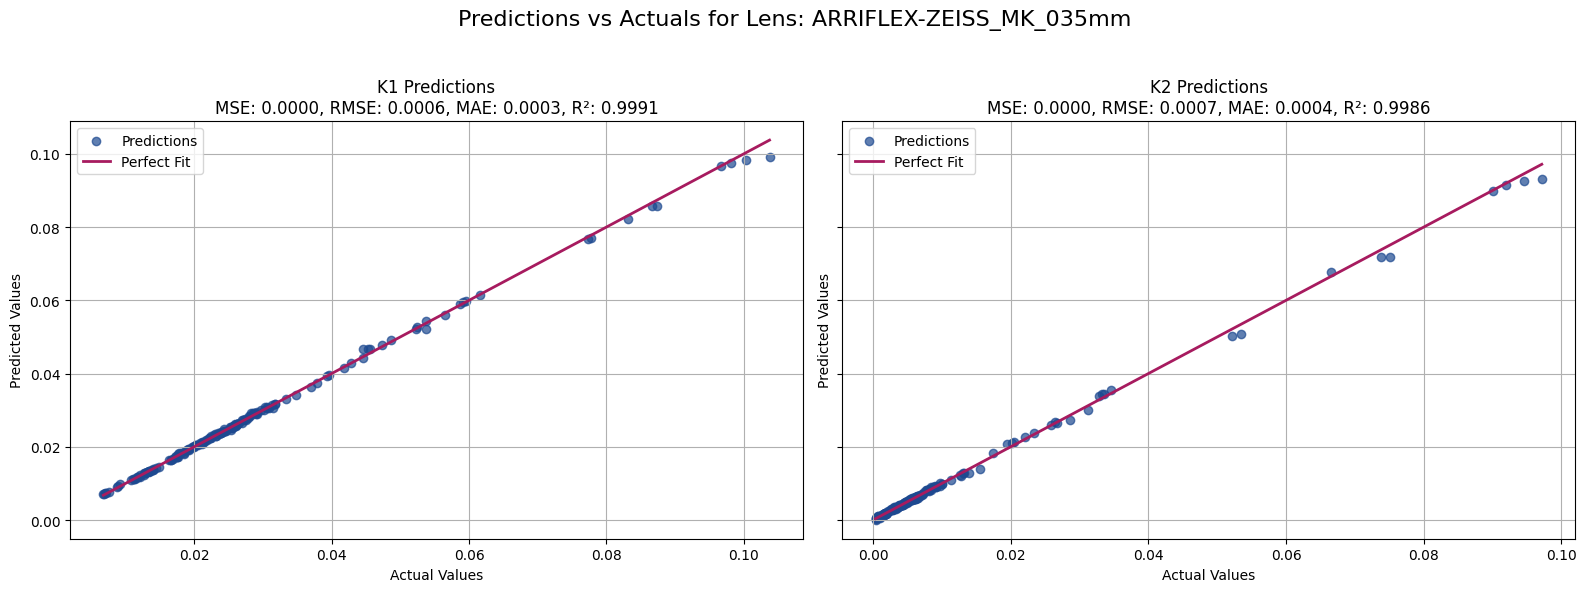

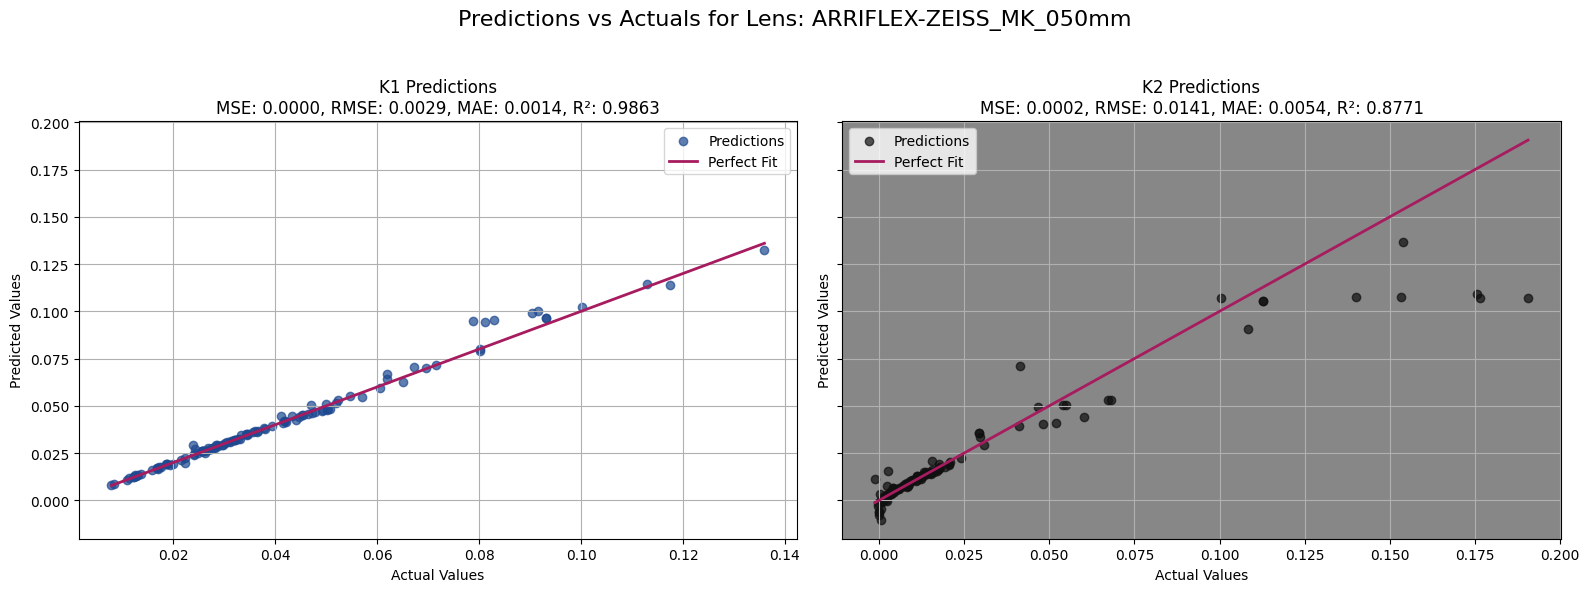

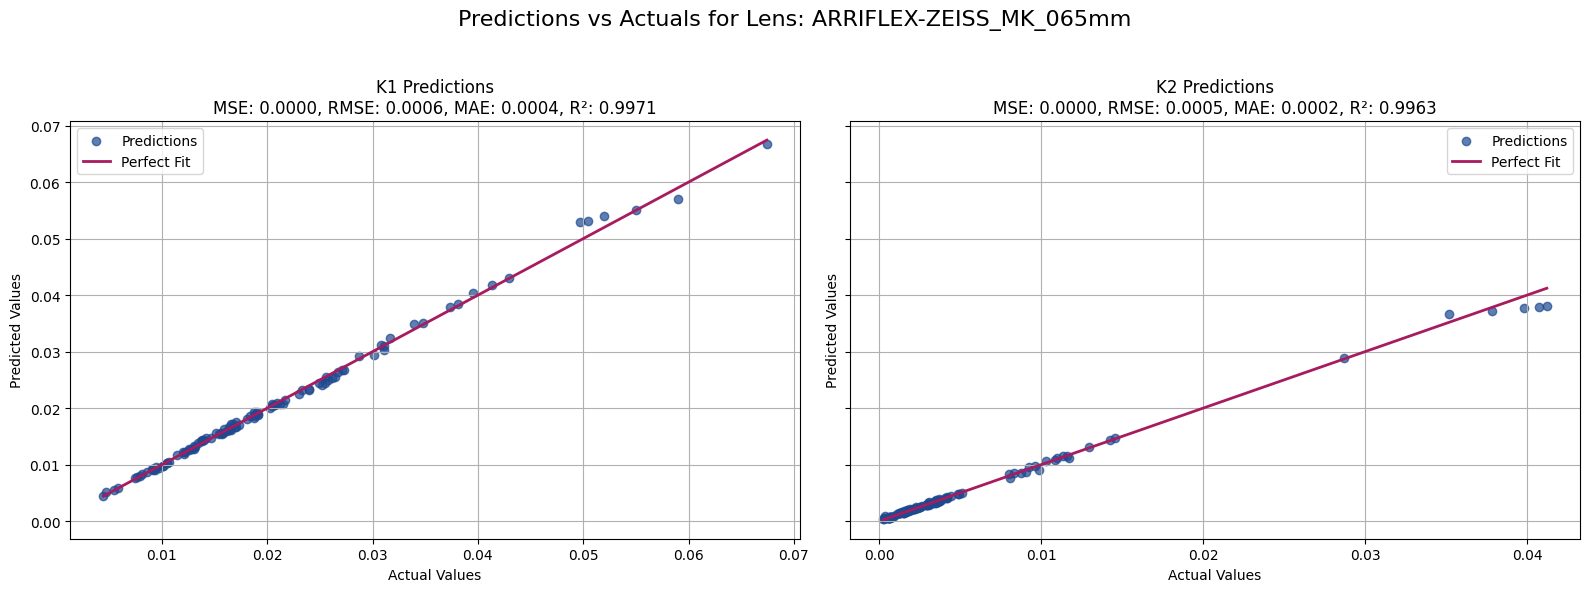

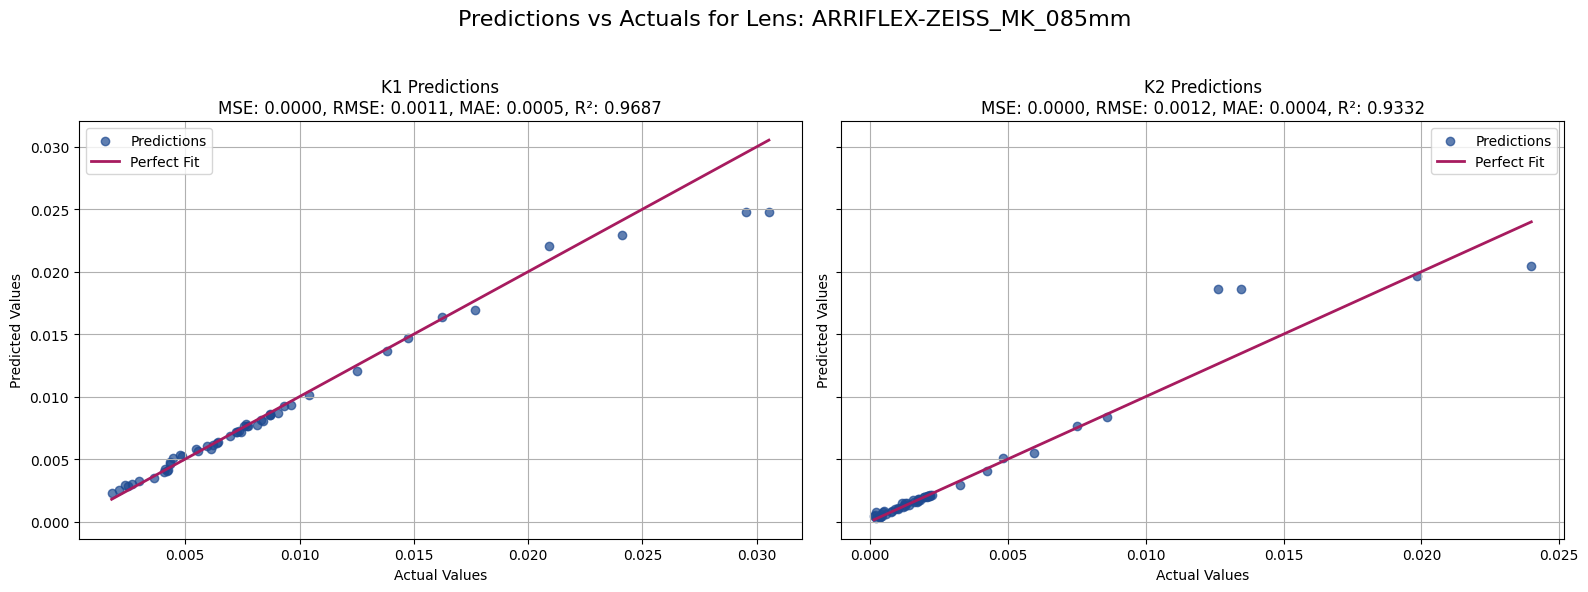

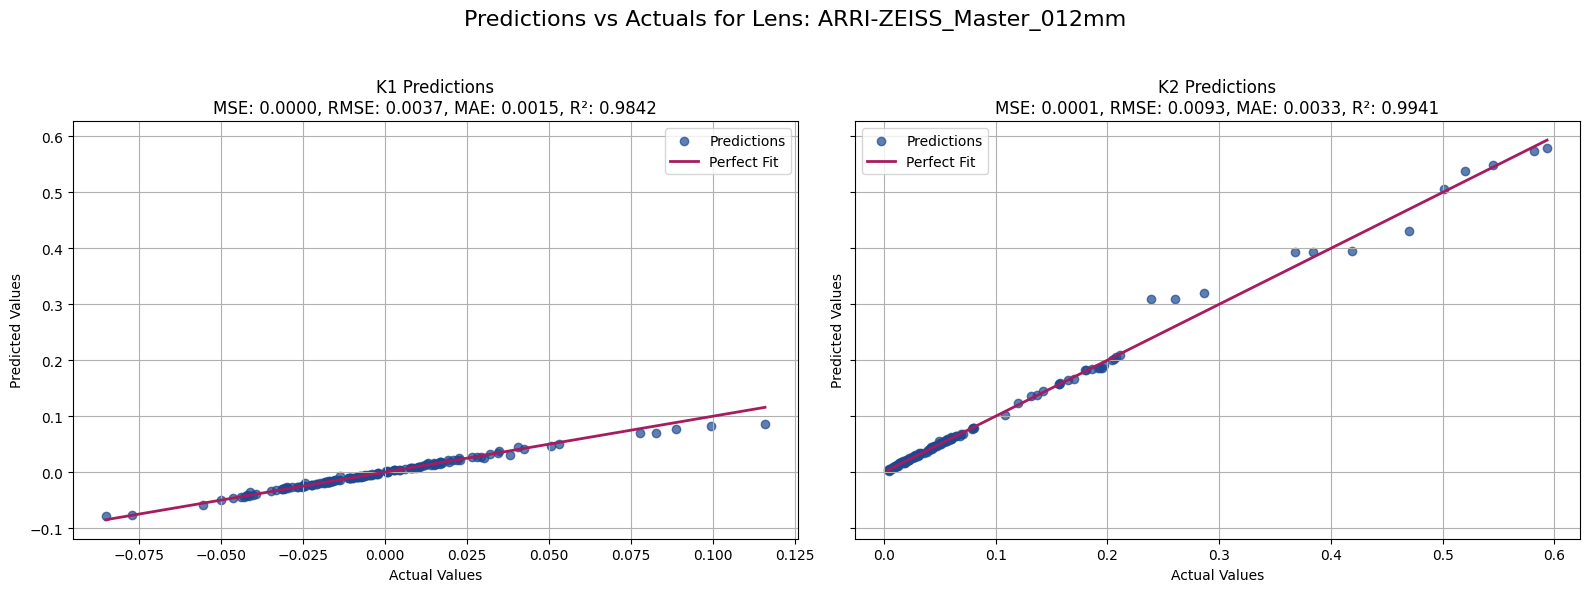

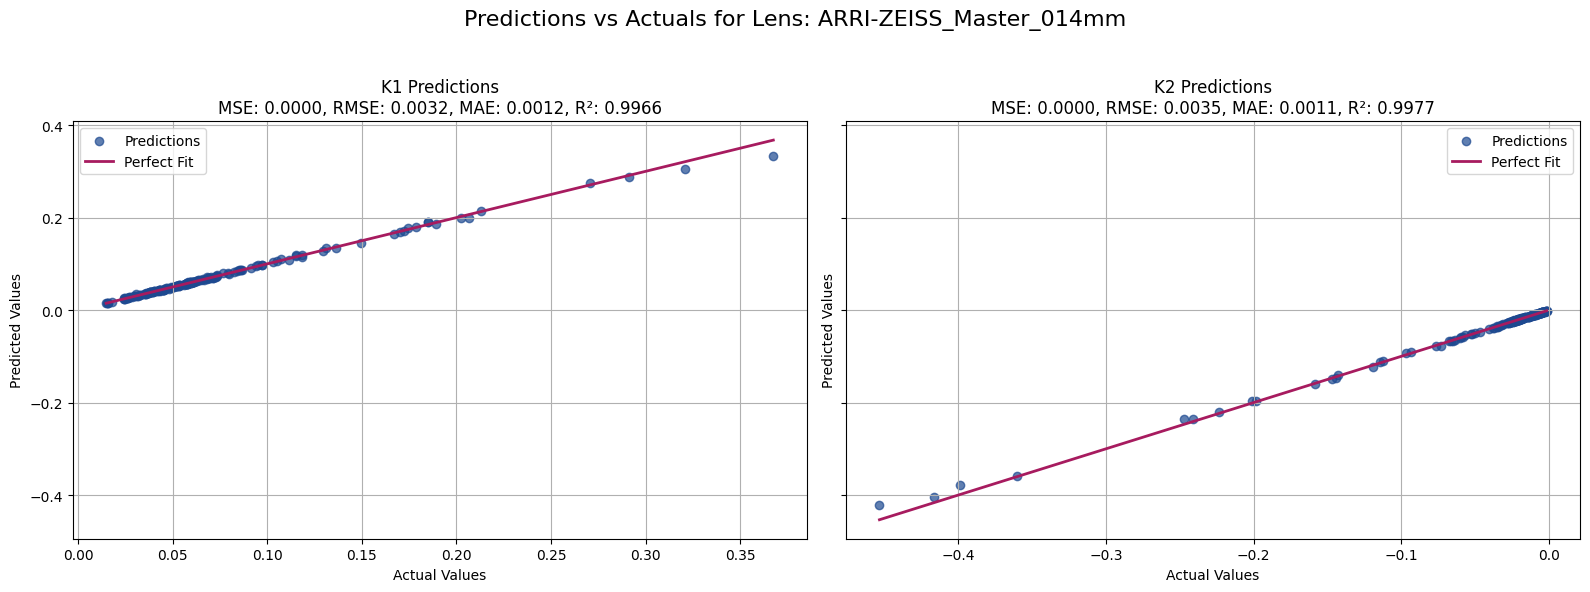

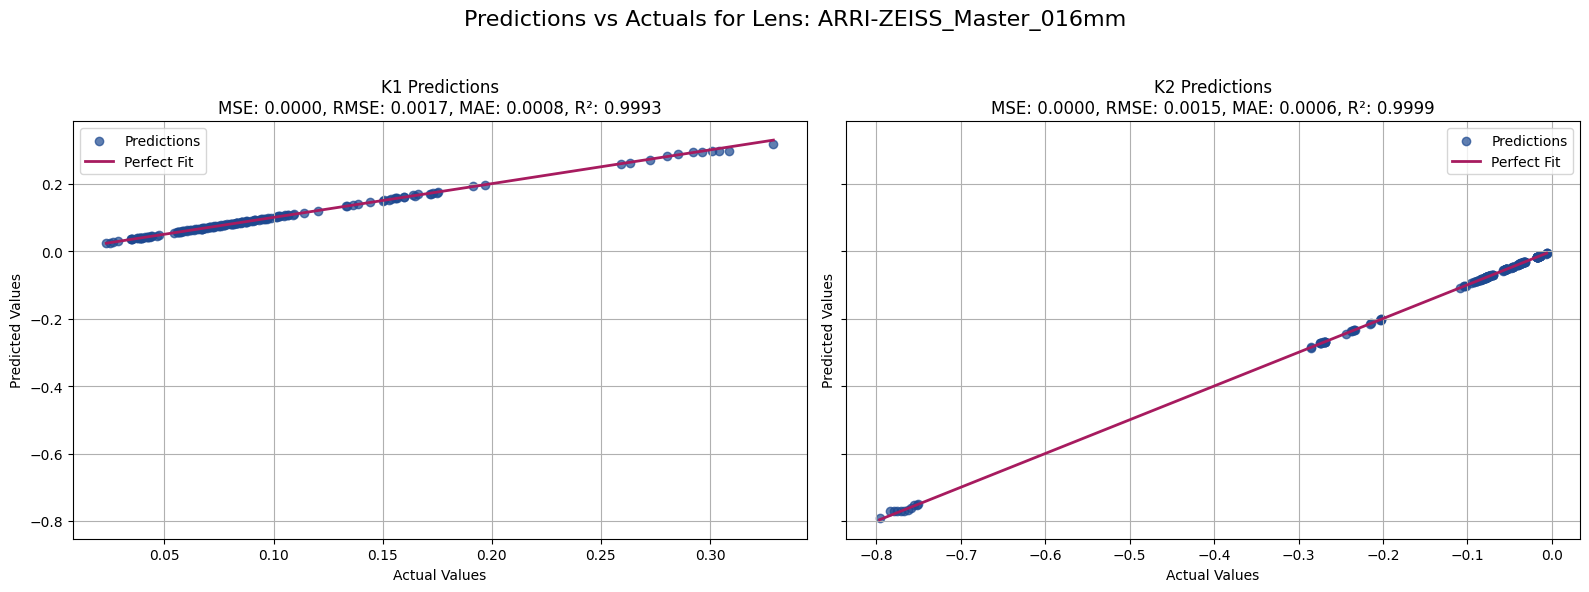

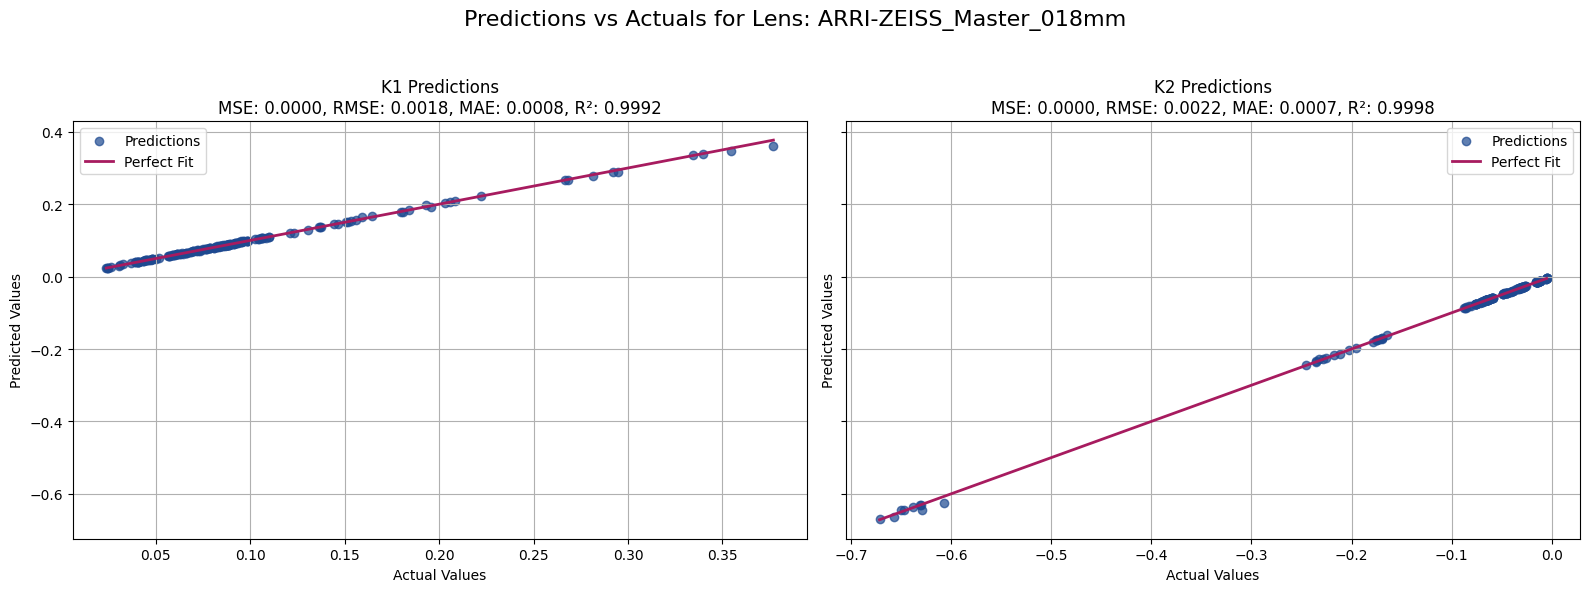

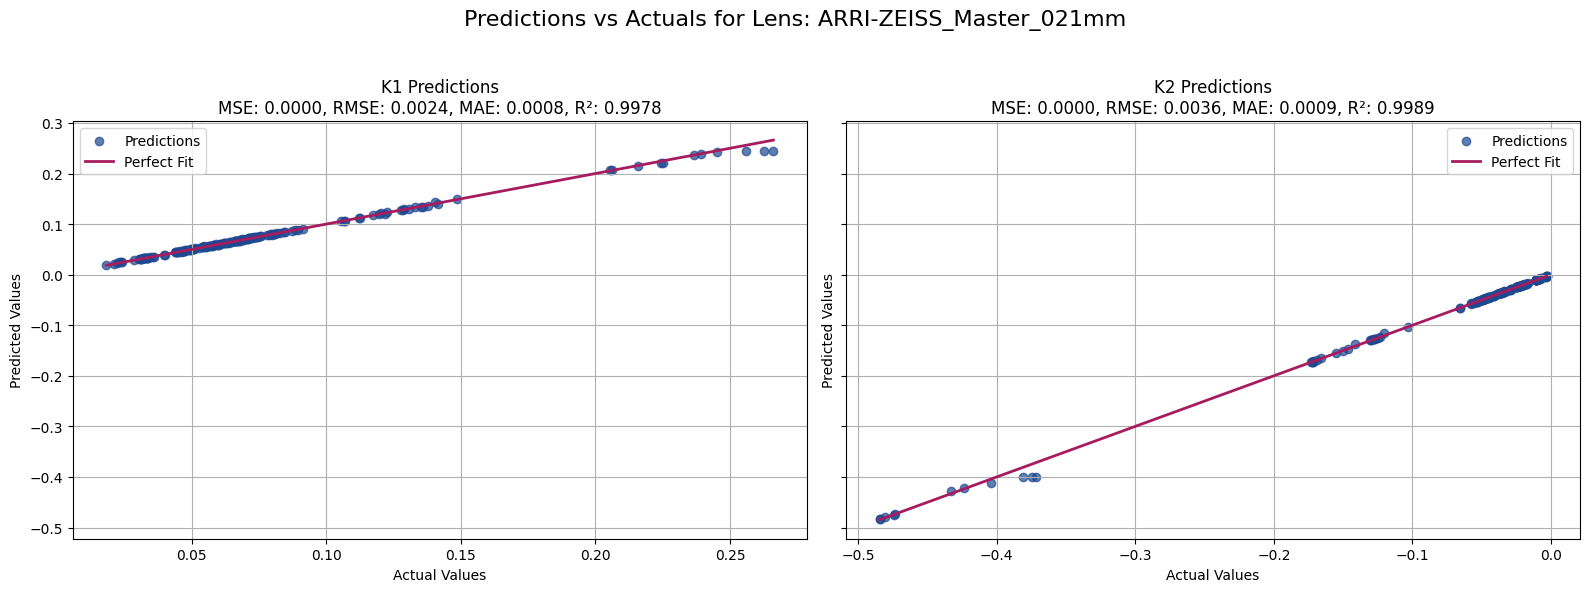

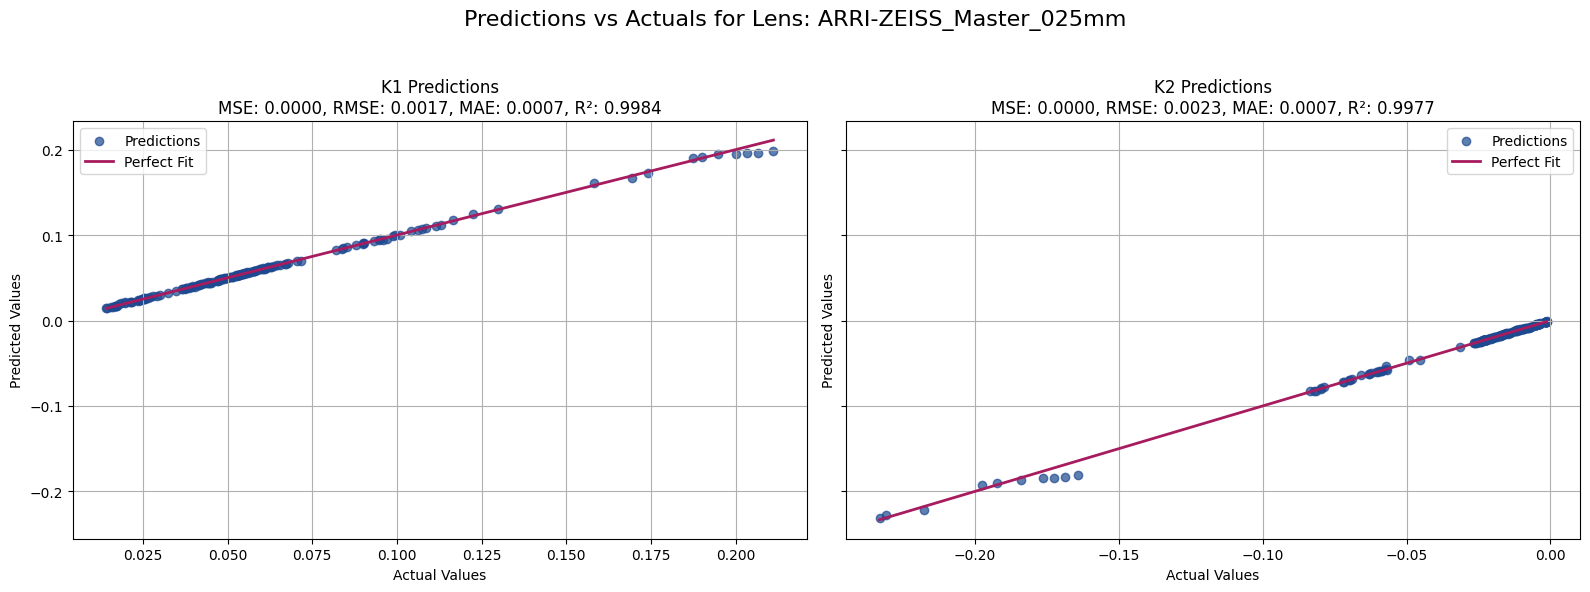

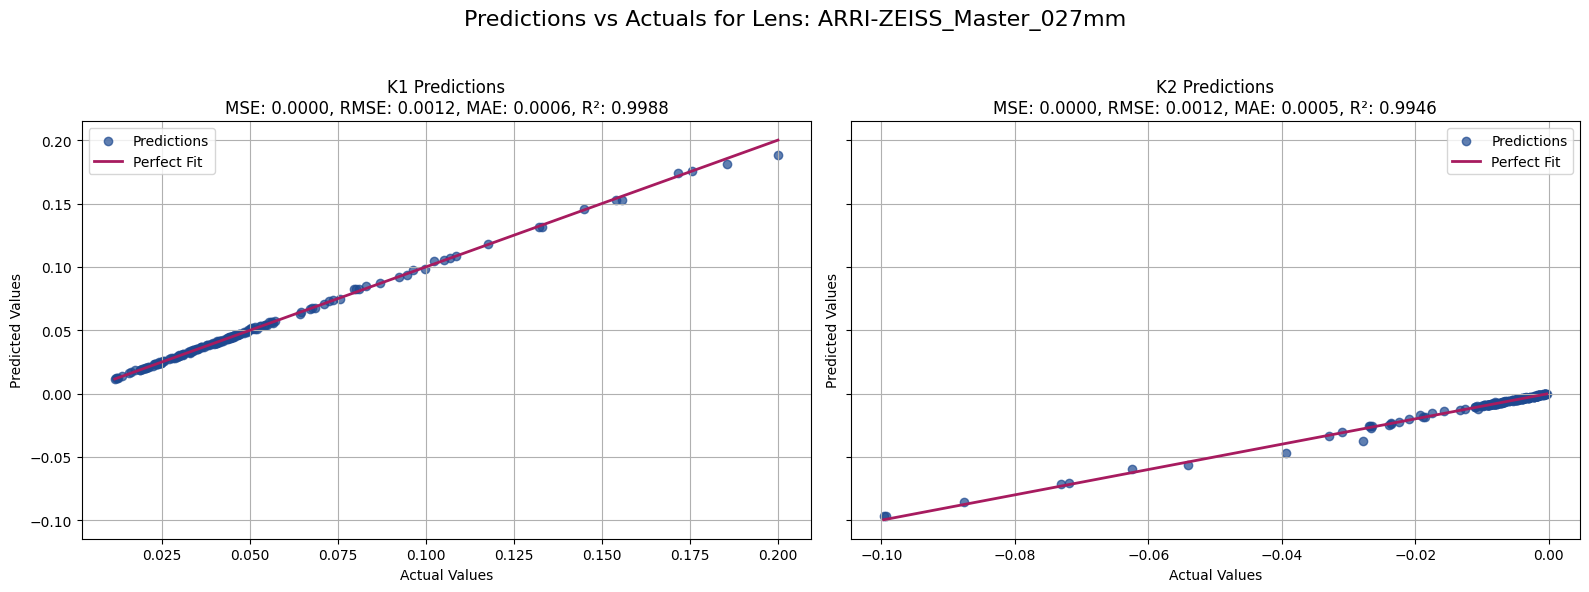

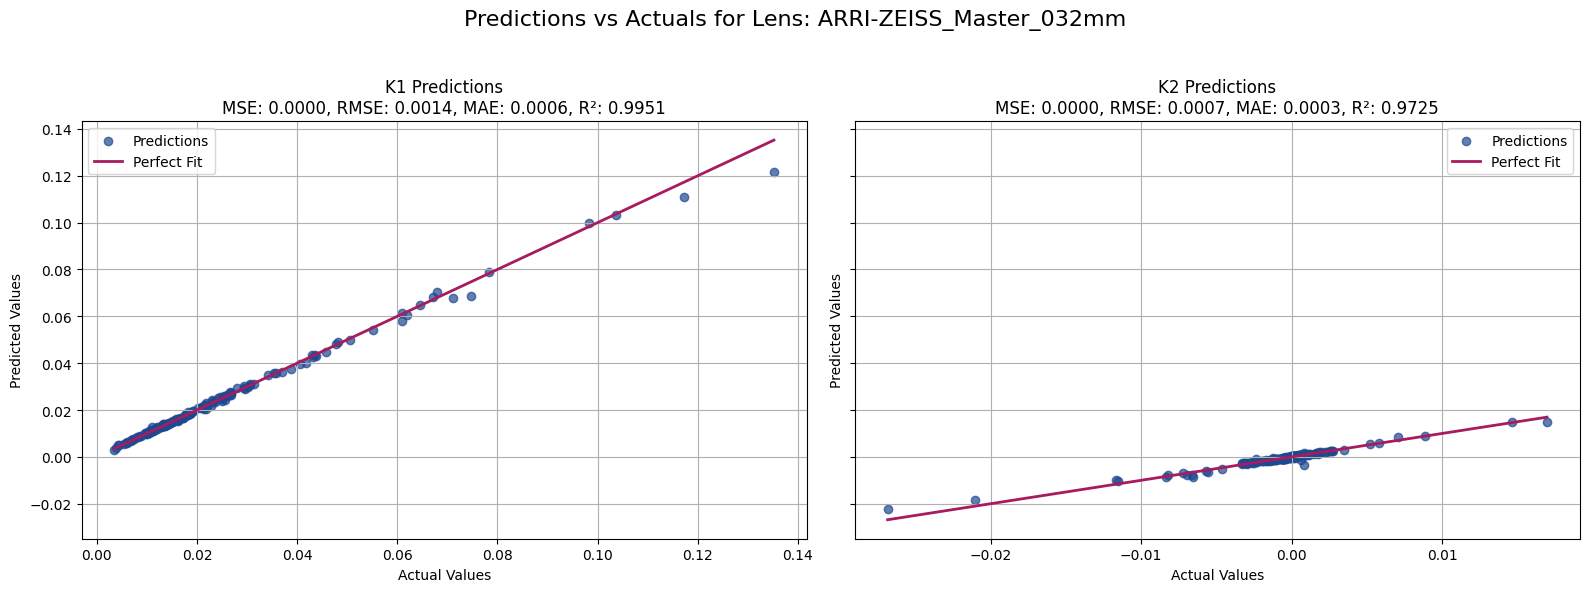

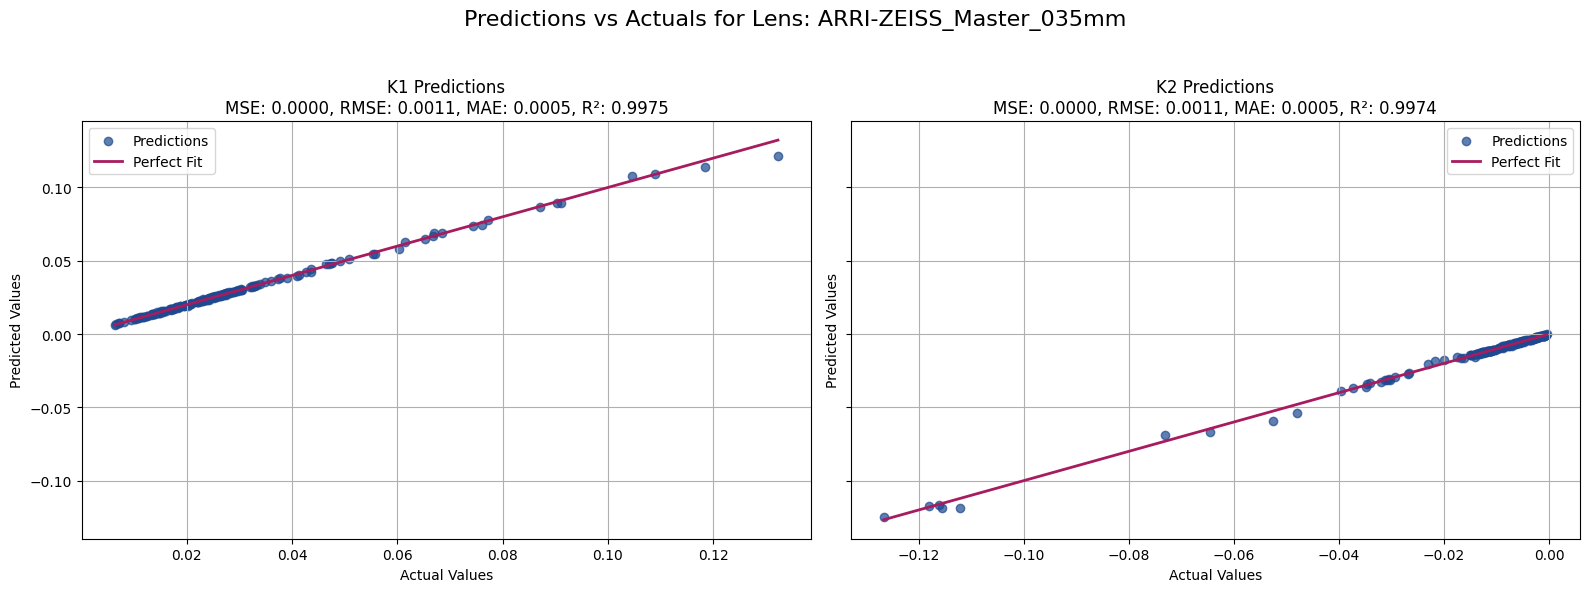

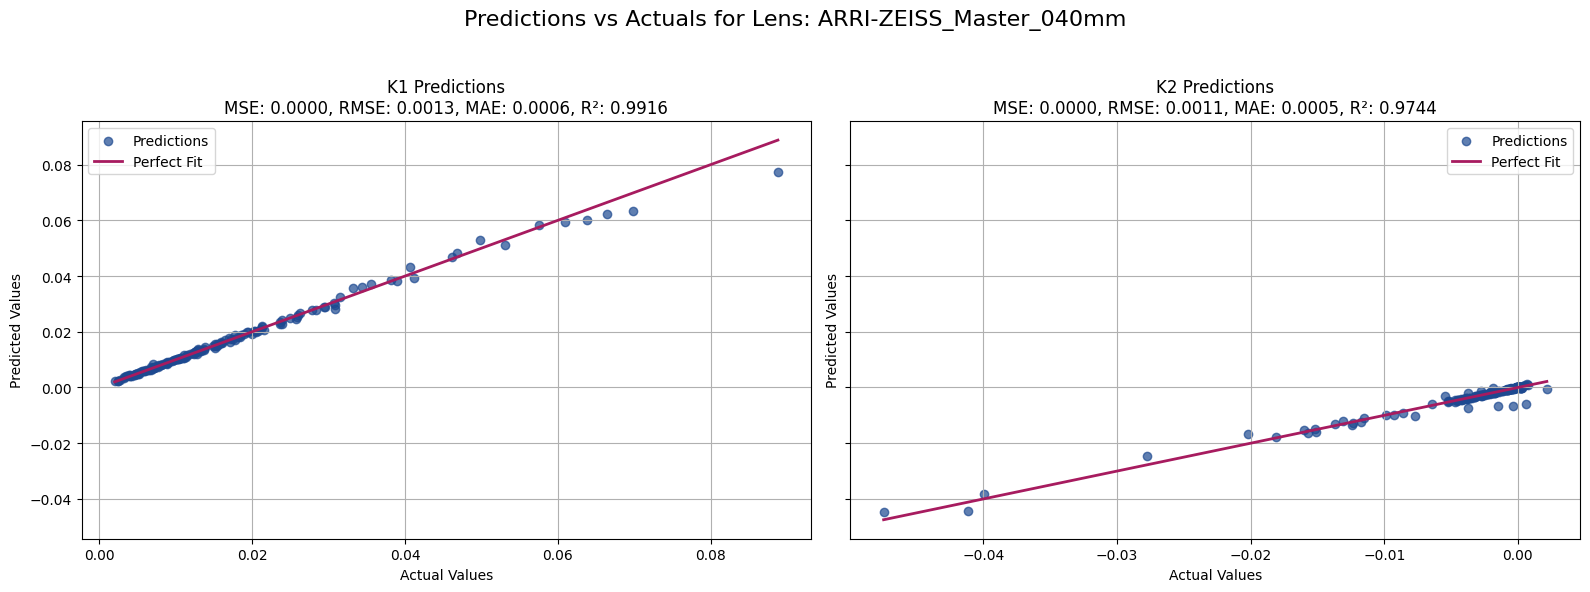

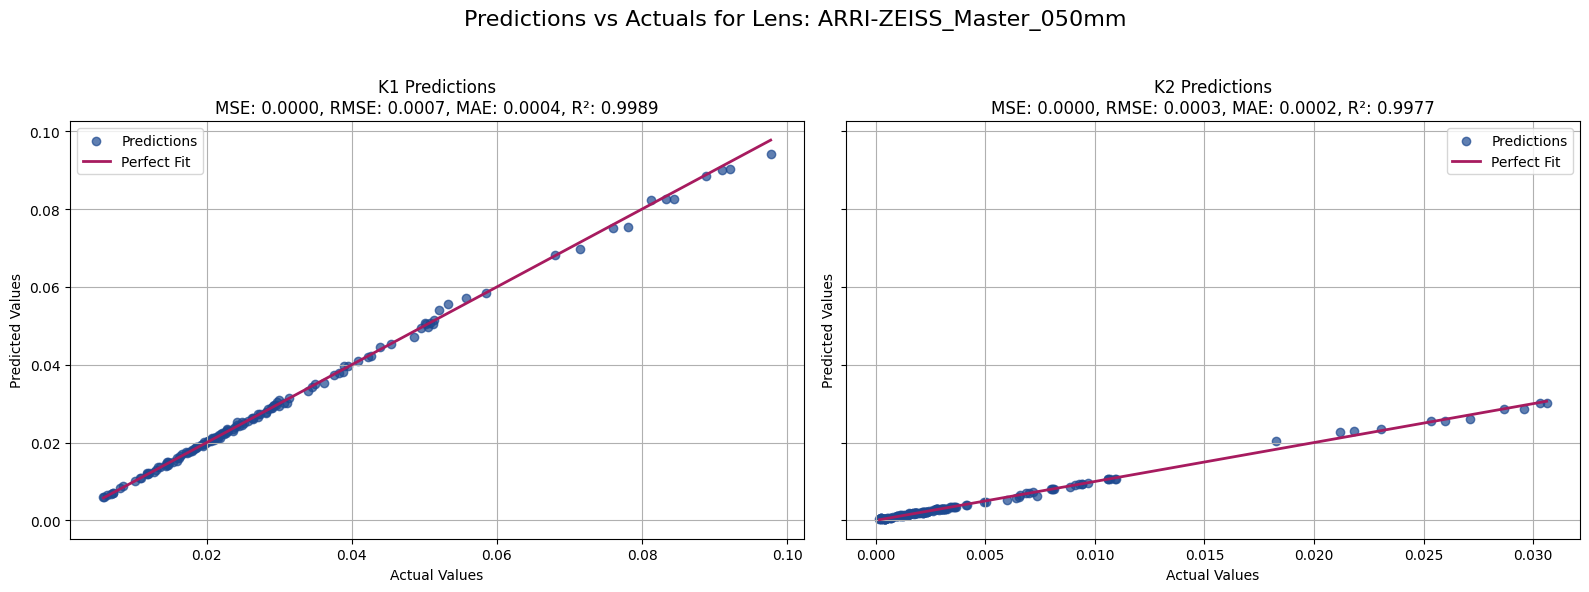

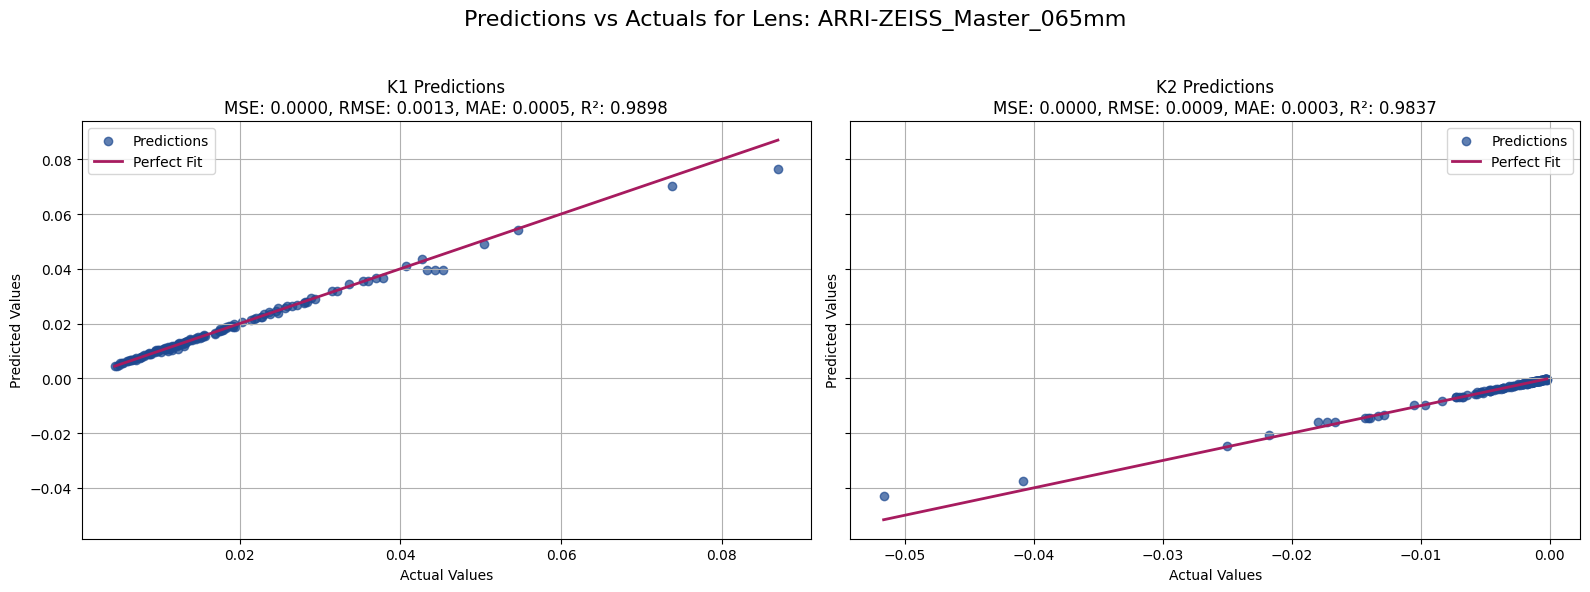

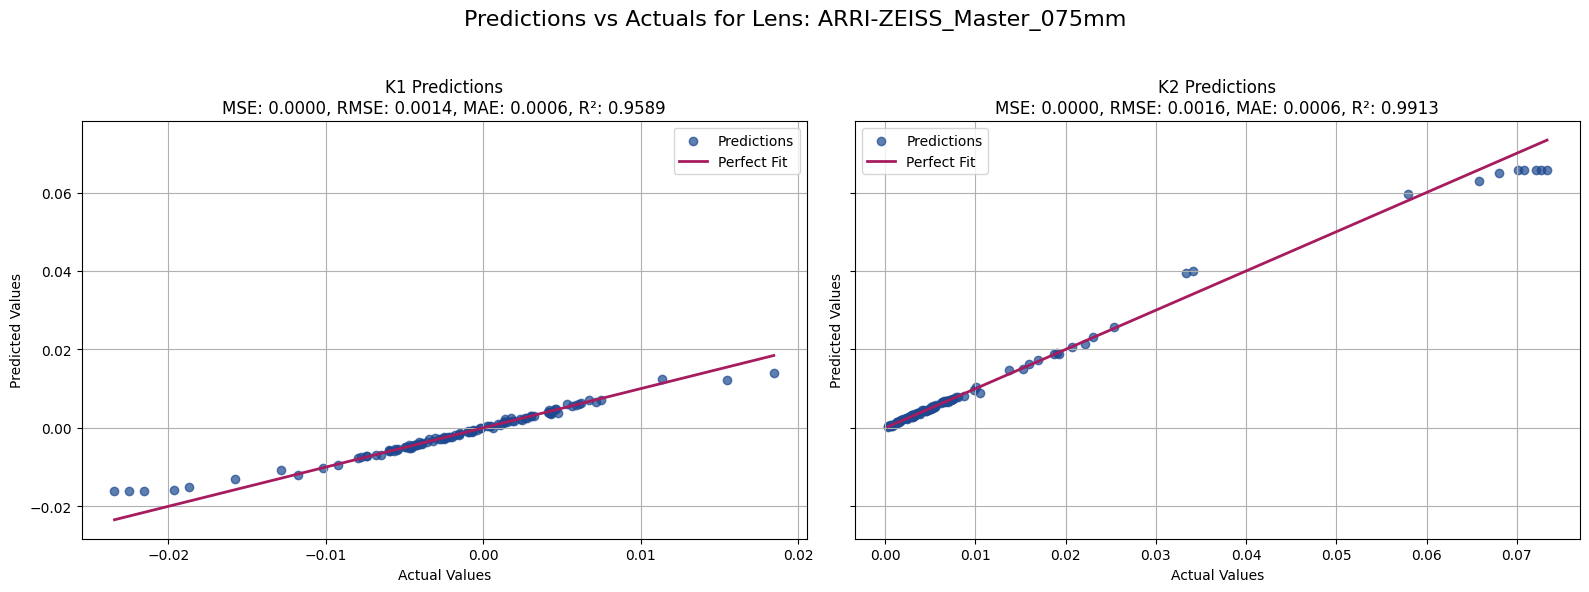

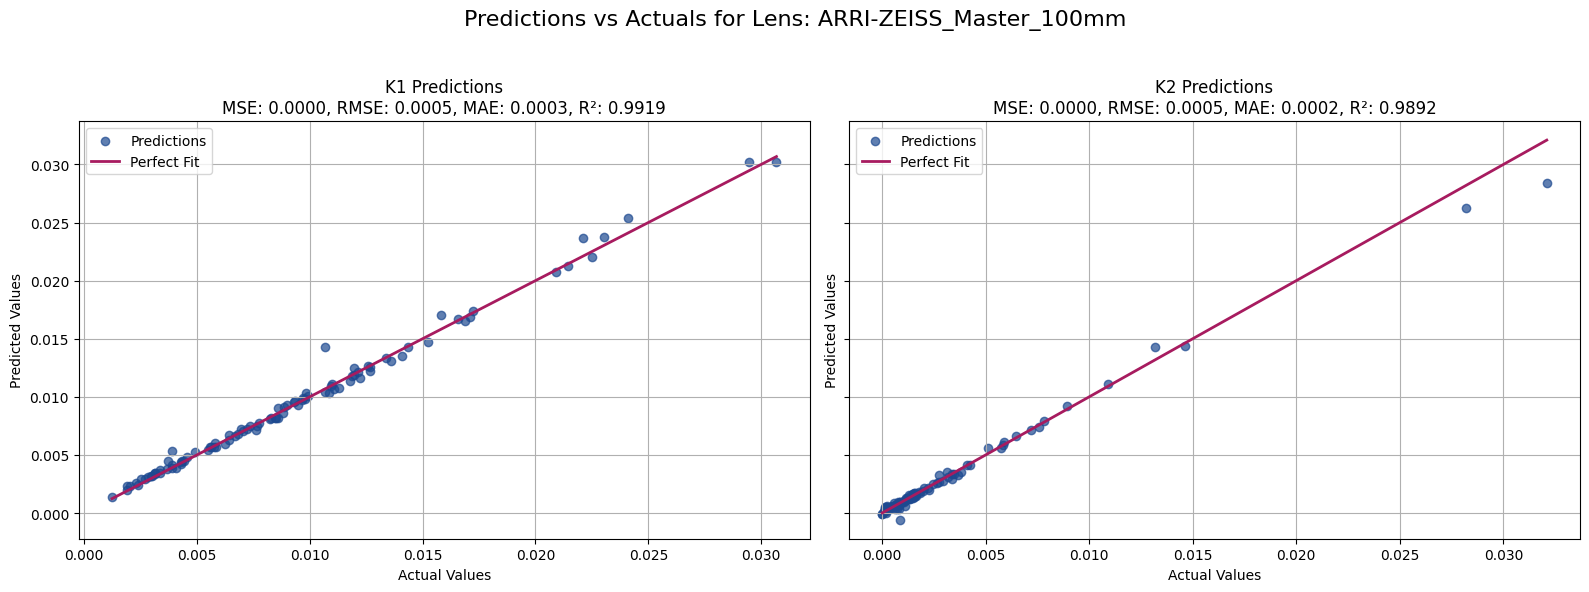

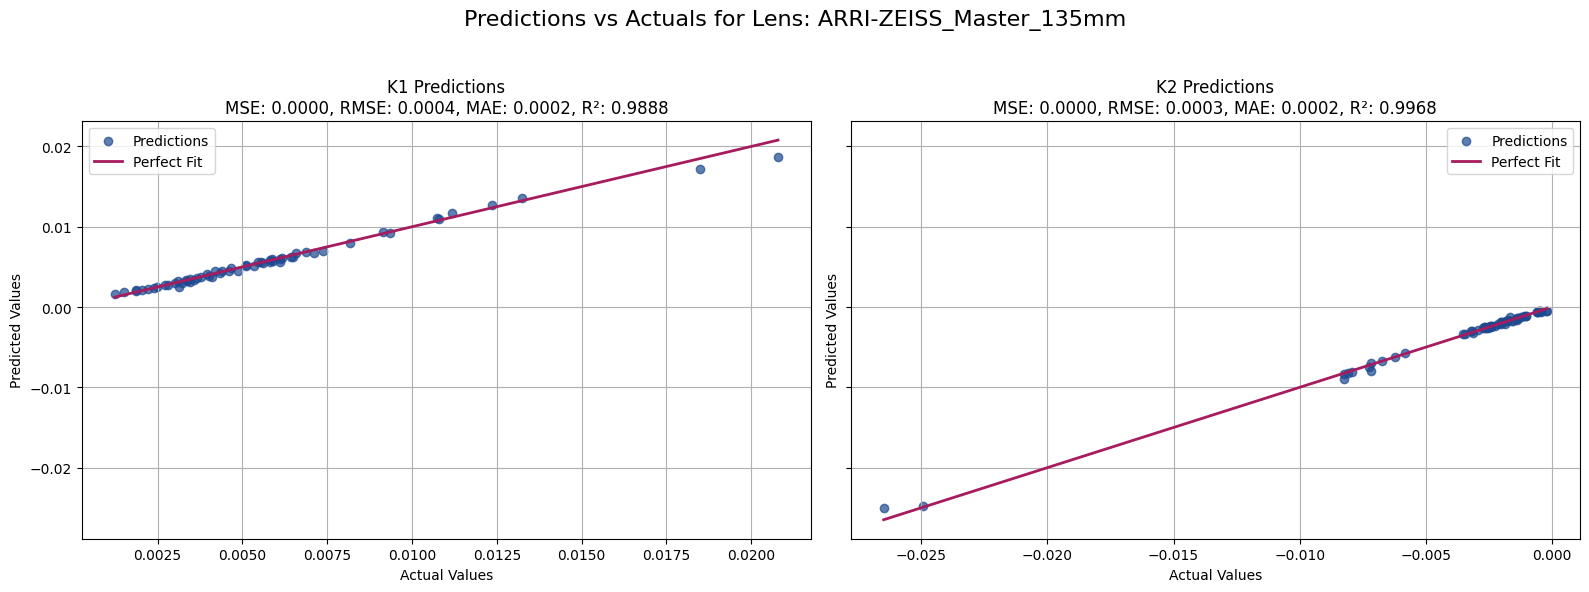

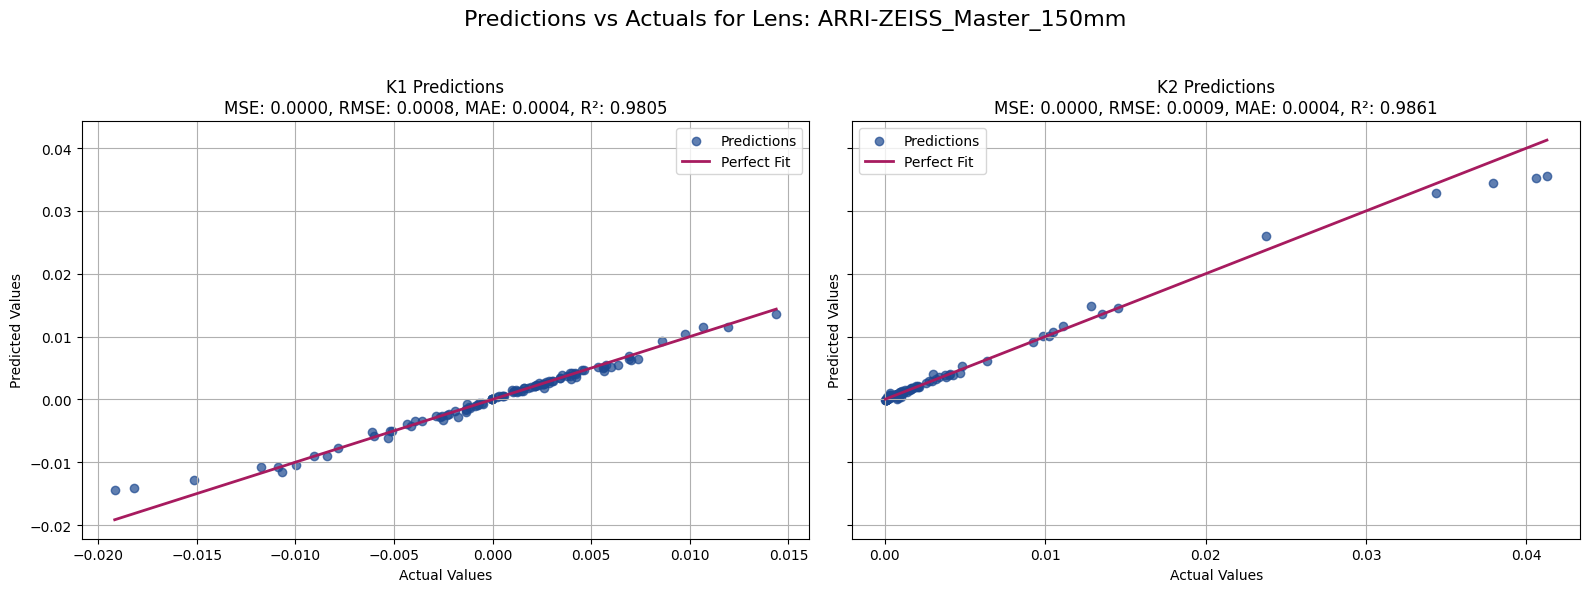

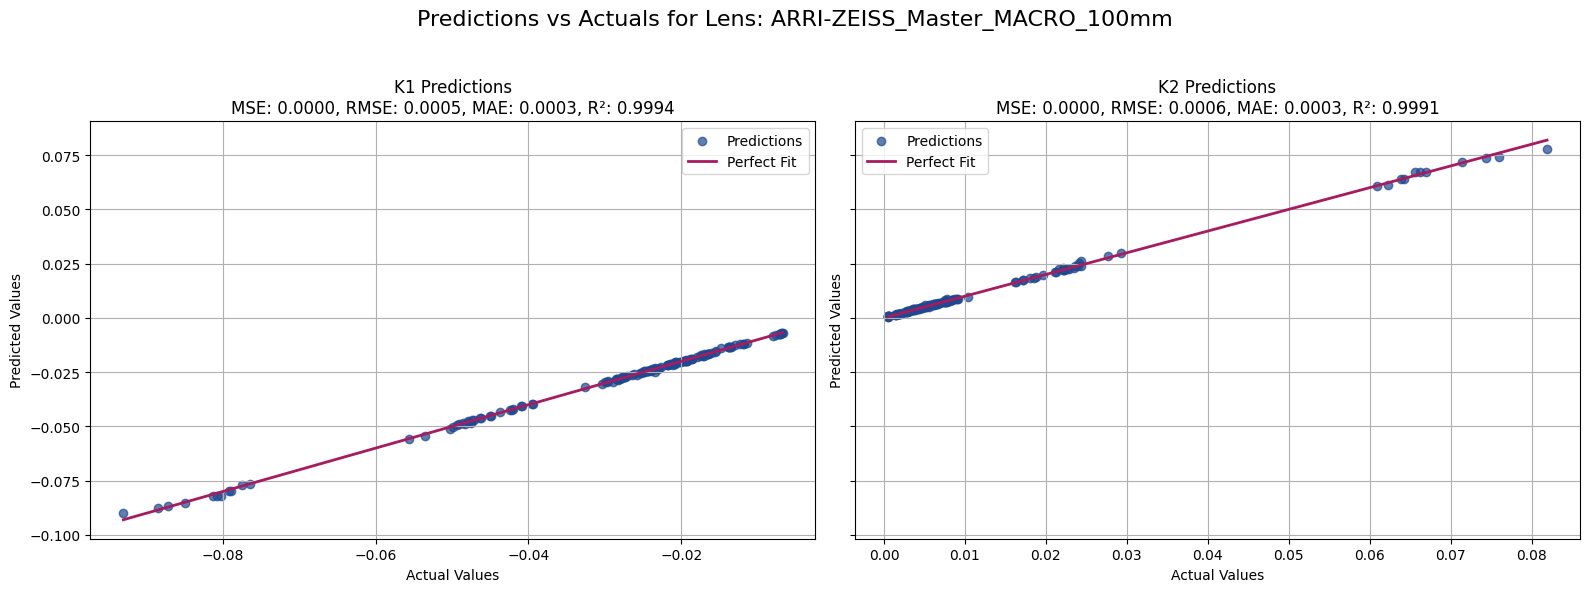

In [33]:
# Plot results for all lenses
for lens, y_test, predictions in lens_results:
    #plot_results(y_test, predictions, lens_name=lens, r2_threshold=.9)
    plot_results(y_test, predictions, lens_name=lens)